# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [73]:
# Import bibliotecas
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import t, ks_2samp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.interpolate import interp1d

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

from pycaret.classification import *

from joblib import dump, load

In [ ]:
# Carregando base
df = pd.read_feather('./../36_modulo/data/credit_scoring.ftr')
dump(df, "./data/df")
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [ ]:
# Obtendo amostra da base para a modelagem, devido ao grande número de instâncias
df_copy = df.sample(frac=.1).copy()

# Convertendo renda para log
df_copy['renda_log'] = np.log(df_copy['renda'])

# Obtendo o valor de mês da data de referência
df_copy['month'] = df_copy['data_ref'].dt.month

# Inserindo dados faltantes com média em tempo de emprego
df_copy.fillna({"tempo_emprego": np.mean(df_copy['tempo_emprego'])}, inplace=True)

# Removendo index da base
df_copy.drop('index', axis=1, inplace=True)
df_copy.head()

,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,renda_log,month
643626,2016-01-01,M,N,S,0,Pensionista,Fundamental,Casado,Casa,65,7.746687,2.0,3608.11,False,8.190939,1
486701,2015-10-01,F,N,S,0,Assalariado,Médio,Viúvo,Casa,47,0.389041,1.0,7627.46,False,8.939510,10
319477,2015-07-01,F,N,N,1,Assalariado,Médio,Viúvo,Casa,50,12.608219,2.0,77195.96,False,11.254102,7
172314,2015-04-01,F,S,S,0,Pensionista,Médio,Casado,Casa,54,7.746687,2.0,10550.26,False,9.263906,4
57326,2015-02-01,F,N,S,0,Assalariado,Superior completo,Solteiro,Casa,39,8.660274,1.0,2995.26,False,8.004786,2


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [ ]:
# Instanciando variável com a base de validação
df_valid = df_copy[df_copy['data_ref'] >= '2015-12-01']

# Instanciando variável com a base de teste
df_train = df_copy[df_copy['data_ref'] < '2015-12-01']
print("Treino:")
print(f"Início -> {df_train['data_ref'].min()} \nFim    -> {df_train['data_ref'].max()}")
print()
print("Validação:")
print(f"Início -> {df_valid['data_ref'].min()} \nFim    -> {df_valid['data_ref'].max()}" )

Treino:
Início -> 2015-01-01 00:00:00 
Fim    -> 2015-11-01 00:00:00

Validação:
Início -> 2015-12-01 00:00:00 
Fim    -> 2016-03-01 00:00:00


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [ ]:
# Descrição da base
print("Treino:")
print(f"Nùm. linhas : {df_train.shape[0]:,.0f}".replace(",","."))
print(f"Nùm. colunas: {df_train.shape[1]:,.0f}".replace(",","."))
print()
print("Validação:")
print(f"Nùm. linhas  : {df_valid.shape[0]:,.0f}".replace(",","."))
print(f"Nùm. colunas : {df_valid.shape[1]:,.0f}".replace(",","."))

Treino:
Nùm. linhas : 55.041
Nùm. colunas: 16

Validação:
Nùm. linhas  : 19.959
Nùm. colunas : 16


In [ ]:
# Número de linhas para cada mês em data_ref na base de treino
df_train.groupby("month")['data_ref'].count()

month
1     5052
2     5015
3     5000
4     4831
5     5063
6     5157
7     4967
8     4946
9     5028
10    4894
11    5088
Name: data_ref, dtype: int64

In [ ]:
# Número de linhas para cada mês em data_ref na base de teste
df_valid.groupby("month")['data_ref'].count()

month
1     4951
2     5074
3     4992
12    4942
Name: data_ref, dtype: int64

In [ ]:
# Verificando as classes das variáveis
df_copy.dtypes

data_ref                 datetime64[ns]
sexo                             object
posse_de_veiculo                 object
posse_de_imovel                  object
qtd_filhos                        int64
tipo_renda                       object
educacao                         object
estado_civil                     object
tipo_residencia                  object
idade                             int64
tempo_emprego                   float64
qt_pessoas_residencia           float64
renda                           float64
mau                                bool
renda_log                       float64
month                             int32
dtype: object

In [ ]:
# Lista com as posições dos gráficos
ax_index = [
    [0,0],[0,1],[0,2],
    [1,0],[1,1],[1,2],
    [2,0],
]
ax_index

[[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2], [2, 0]]

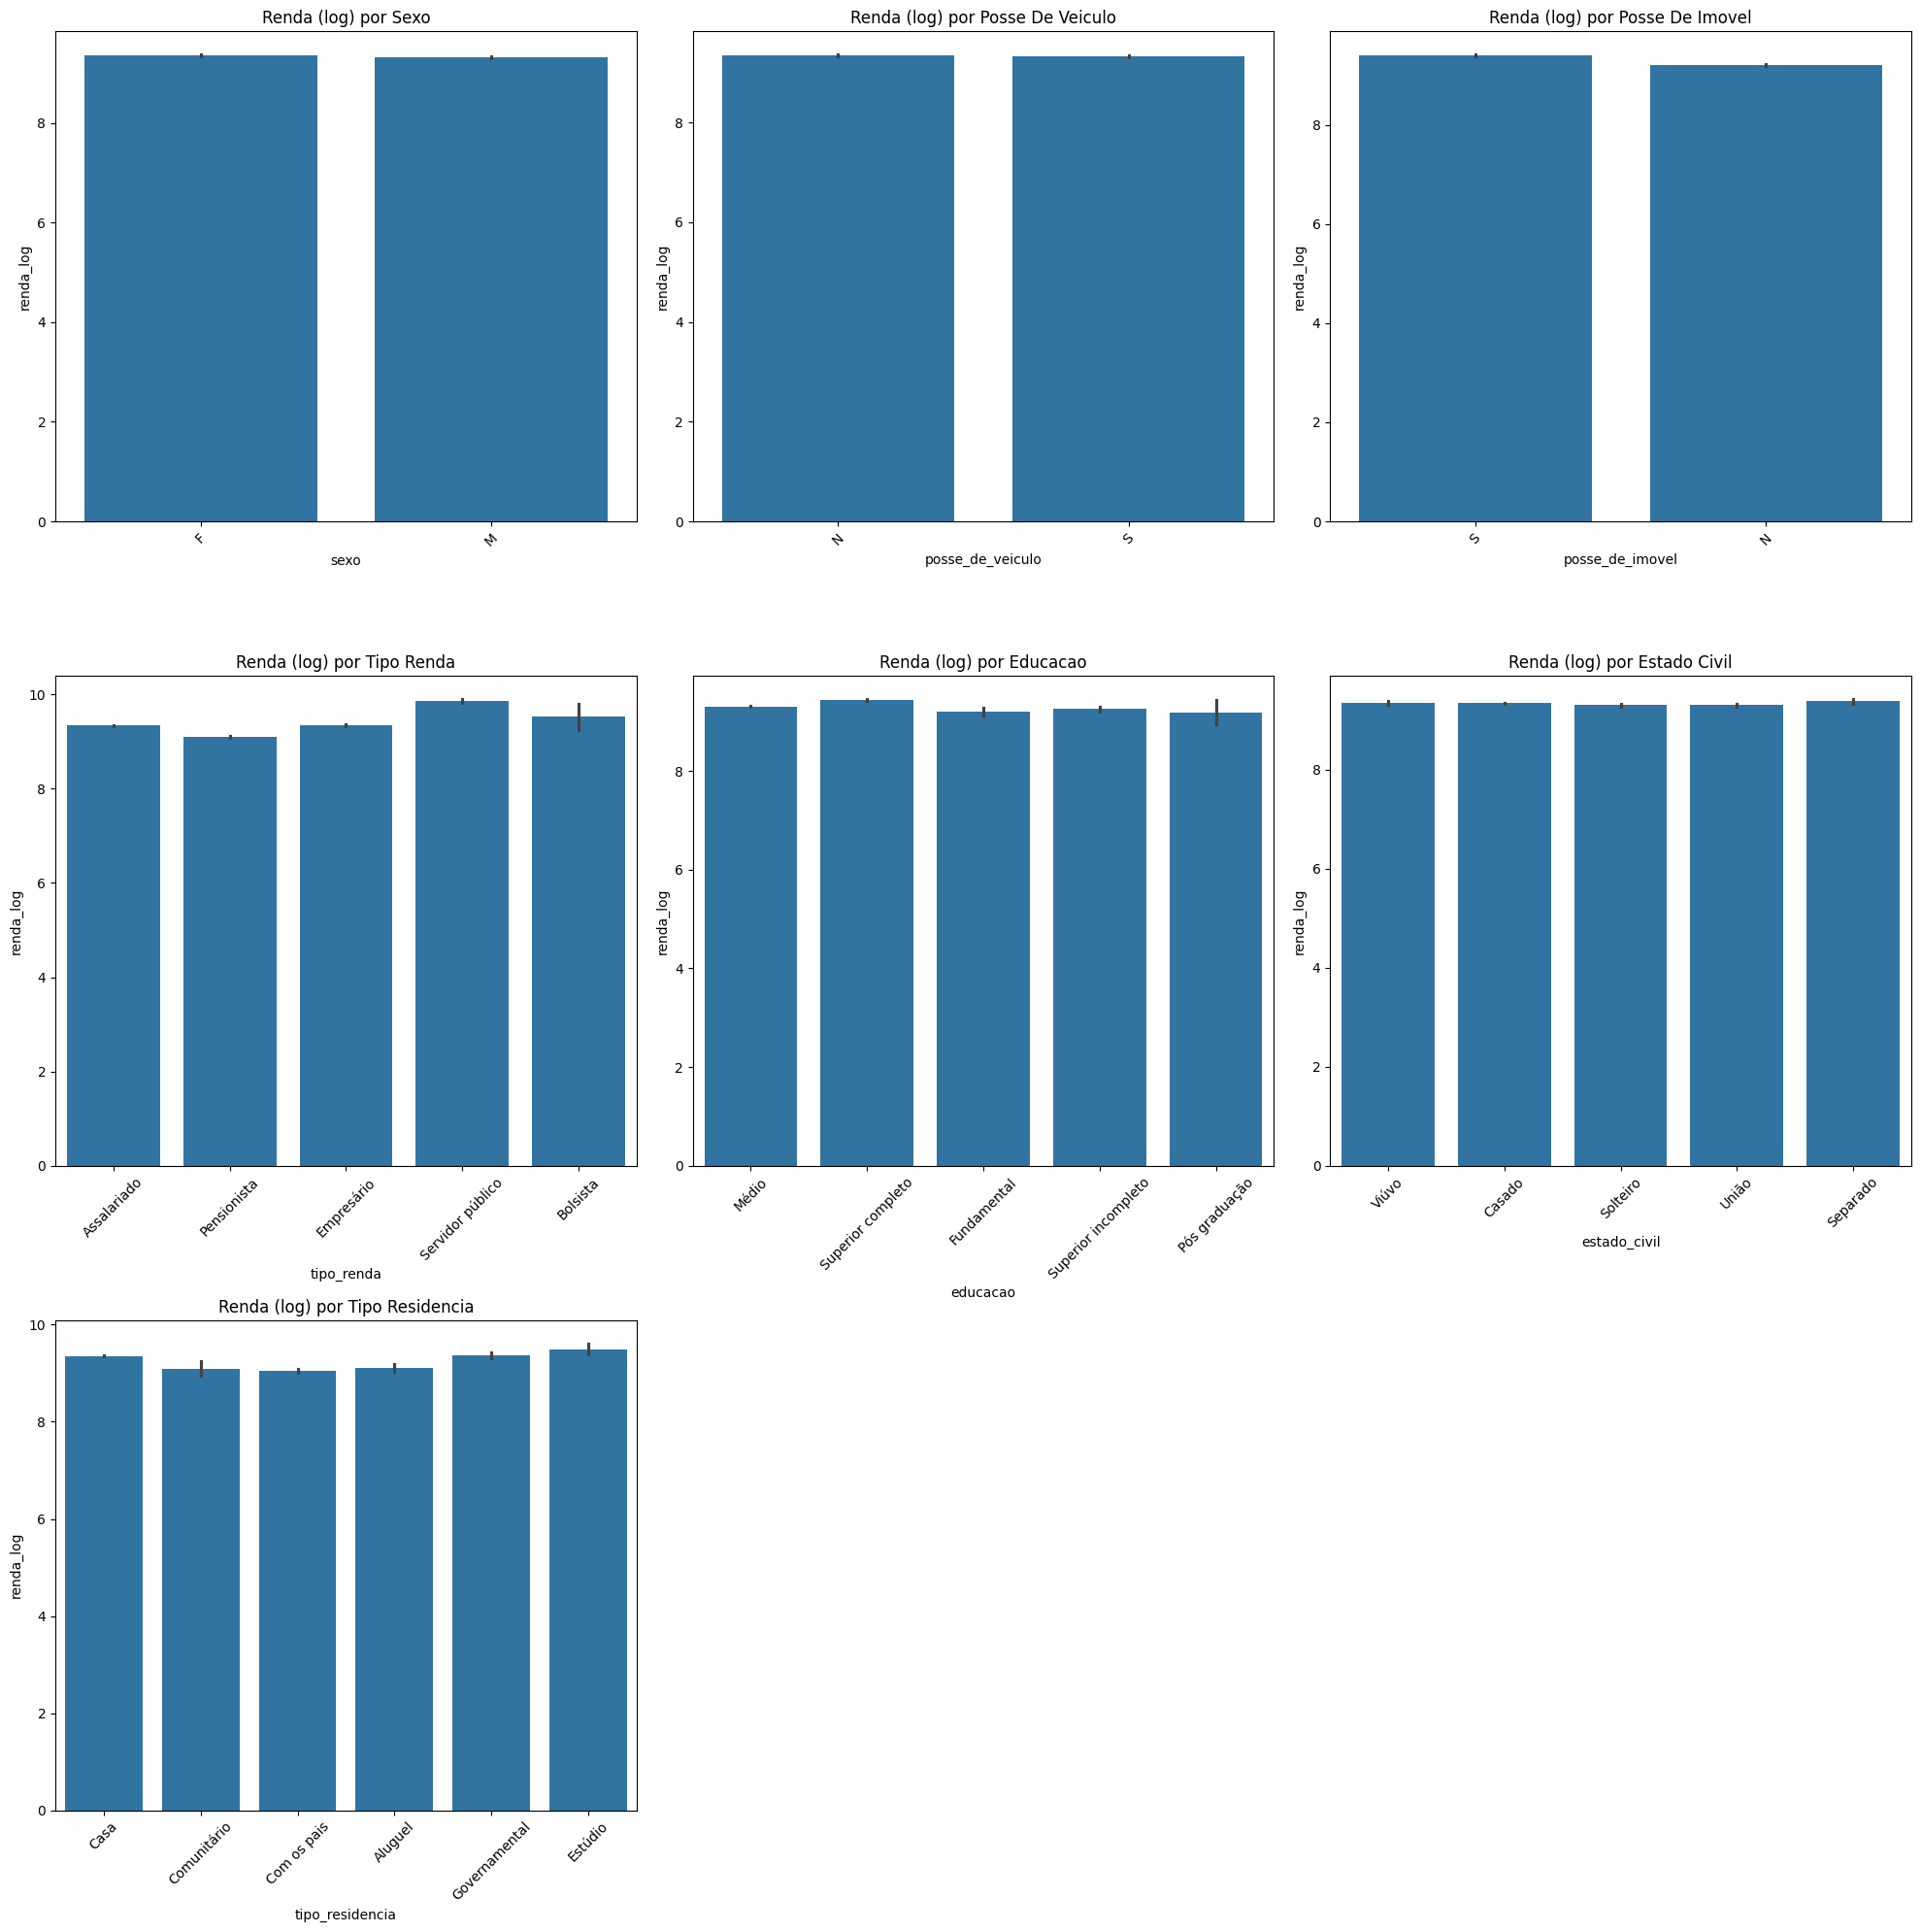

In [ ]:
# Análise univariáda de variáveis categóricas, base treino
fig, ax = plt.subplots(3,3, figsize=(20,20))
for k, v in enumerate(df_copy.select_dtypes("object").dtypes.index):
    g = sns.barplot(
        x=v,
        y='renda_log',
        data=df_train,
        ax=ax[ax_index[k][0], ax_index[k][1]]
    )
    g.set(title=f"Renda (log) por {v.title().replace('_', ' ')}")
    for item in g.get_xticklabels():
        item.set_rotation(45)
    plt.tight_layout()
ax[2,1].set_axis_off()
ax[2,2].set_axis_off()
plt.show()

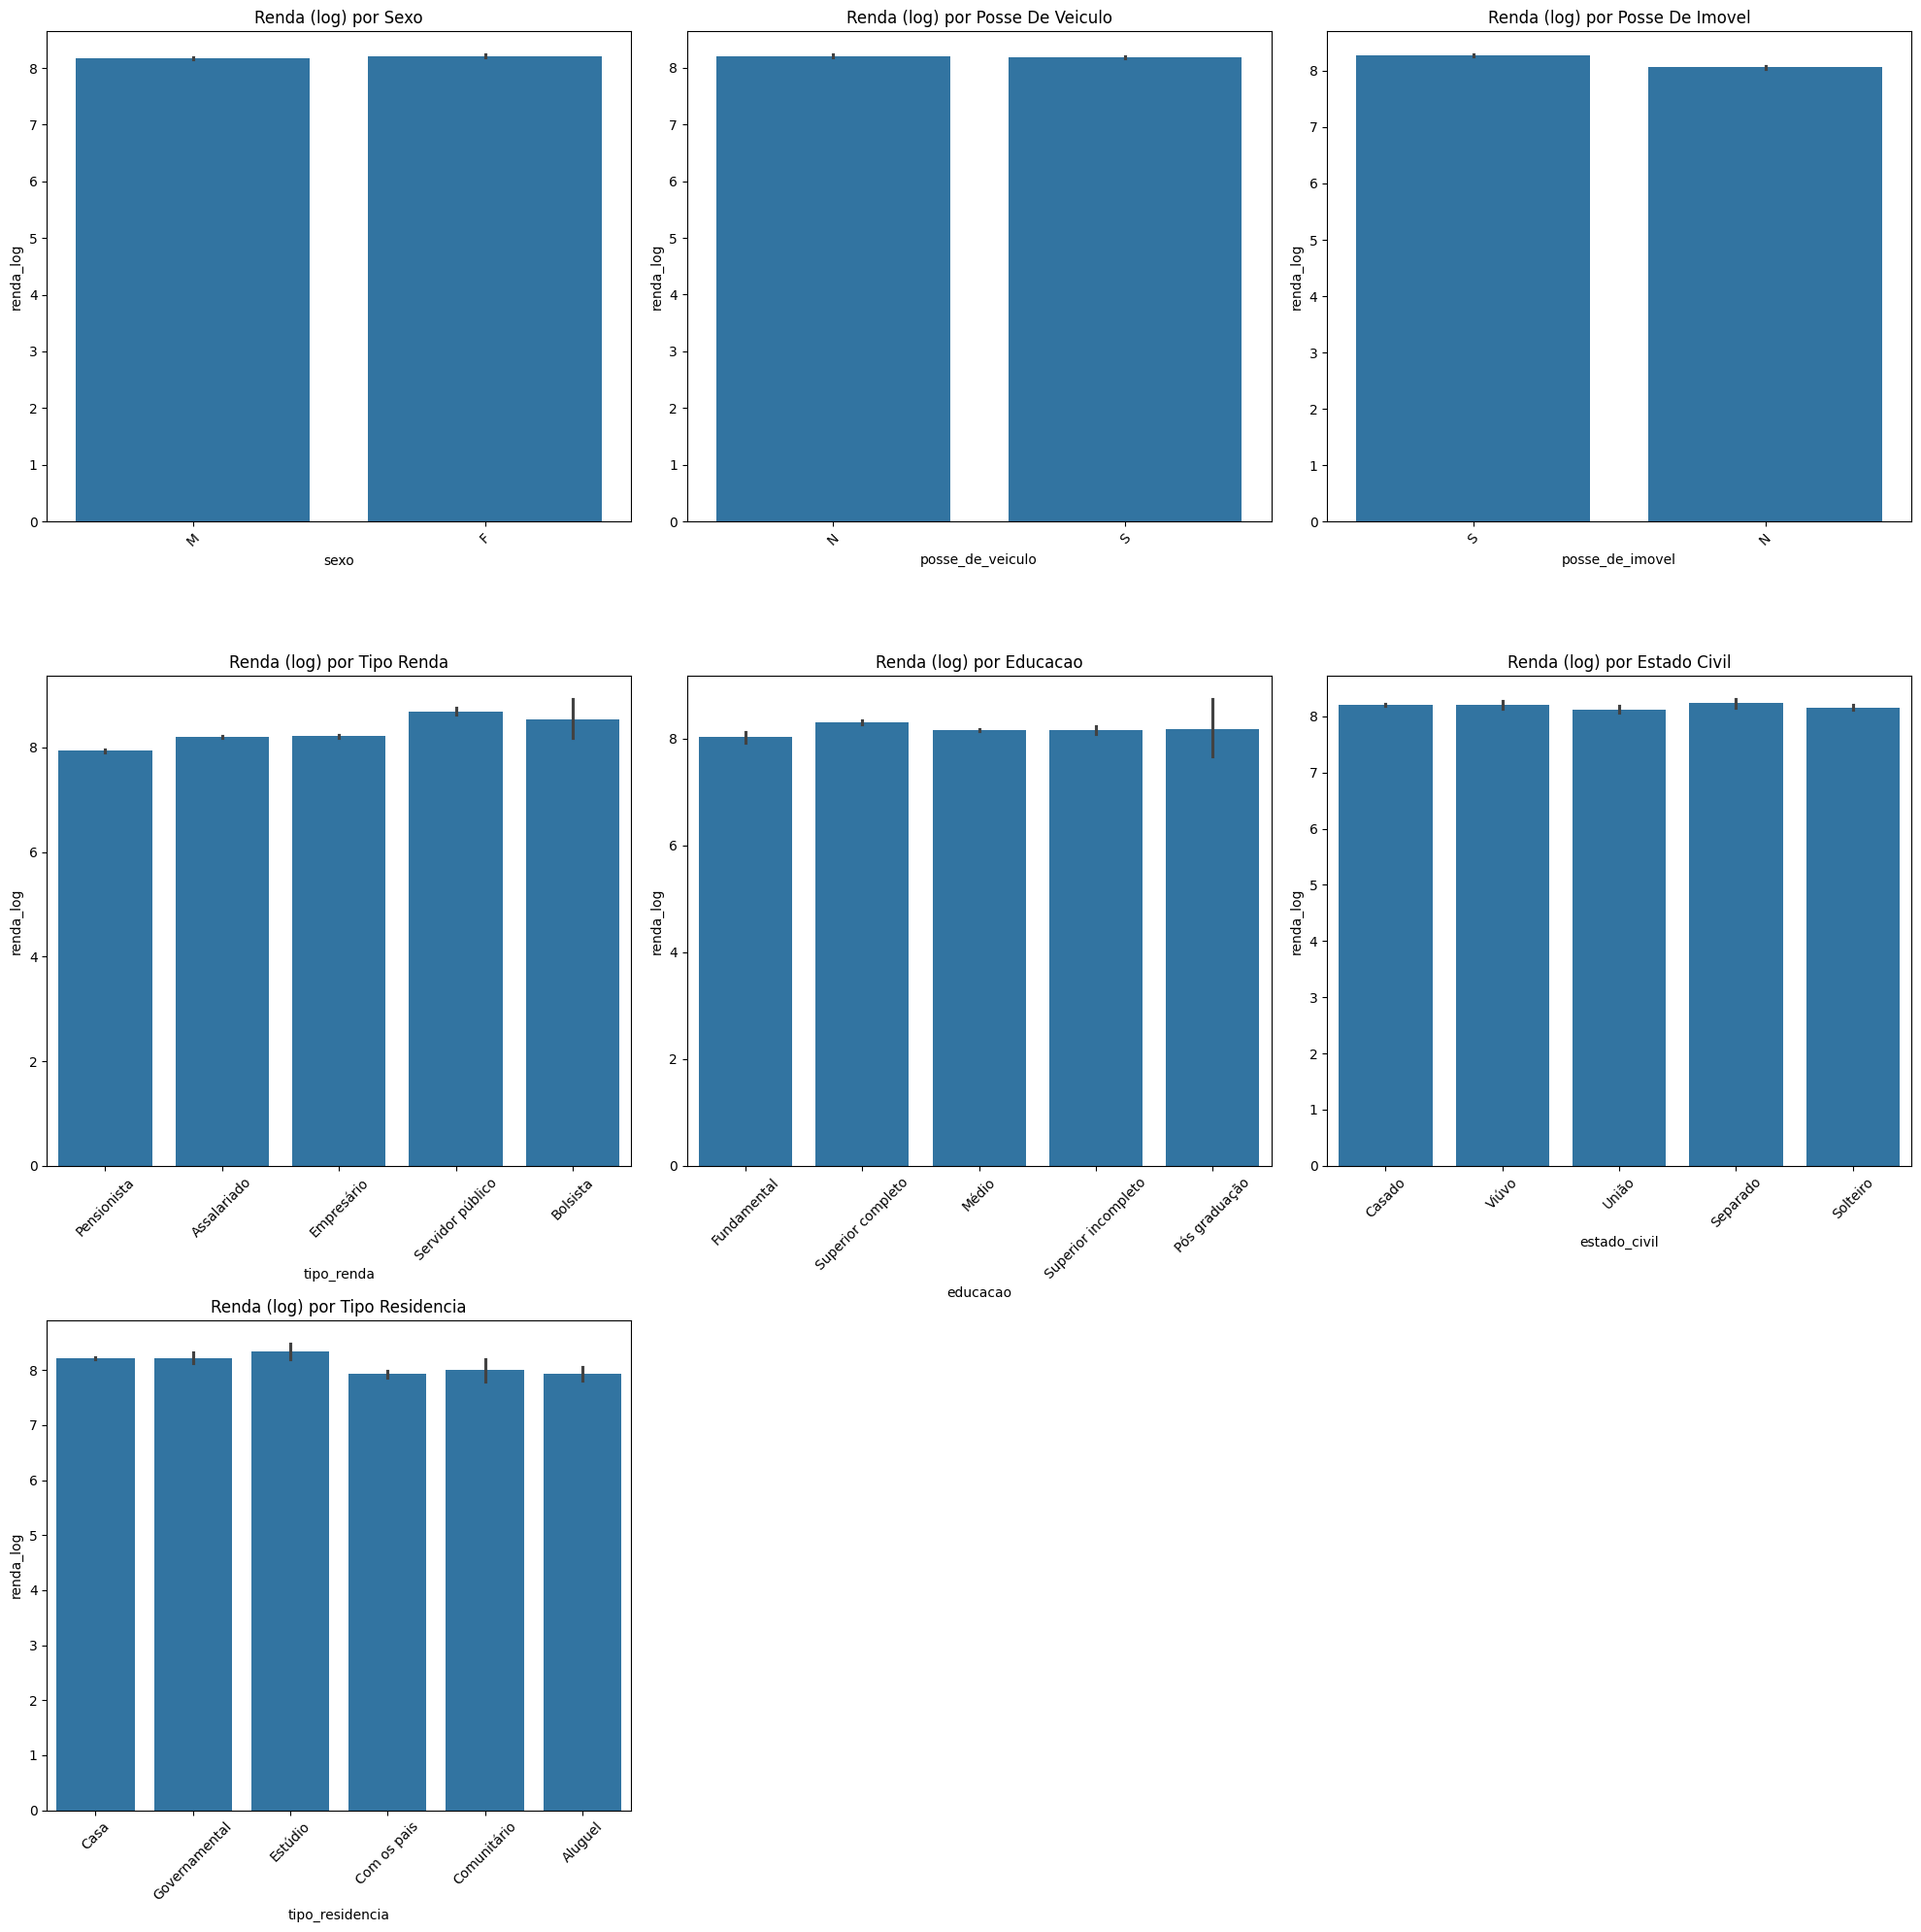

In [ ]:
# Análise univariáda de variáveis categóricas, base validação
fig, ax = plt.subplots(3,3, figsize=(20,20))
for k, v in enumerate(df_copy.select_dtypes("object").dtypes.index):
    g = sns.barplot(
        x=v,
        y='renda_log',
        data=df_valid,
        ax=ax[ax_index[k][0], ax_index[k][1]]
    )
    g.set(title=f"Renda (log) por {v.title().replace('_', ' ')}")
    for item in g.get_xticklabels():
        item.set_rotation(45)
    plt.tight_layout()
ax[2,1].set_axis_off()
ax[2,2].set_axis_off()
plt.show()

In [ ]:
# Variáveis contínuas e discretas
df_train.select_dtypes(["float64","int32"]).dtypes.index

Index(['tempo_emprego', 'qt_pessoas_residencia', 'renda', 'renda_log',
       'month'],
      dtype='object')

<function matplotlib.pyplot.show(close=None, block=None)>

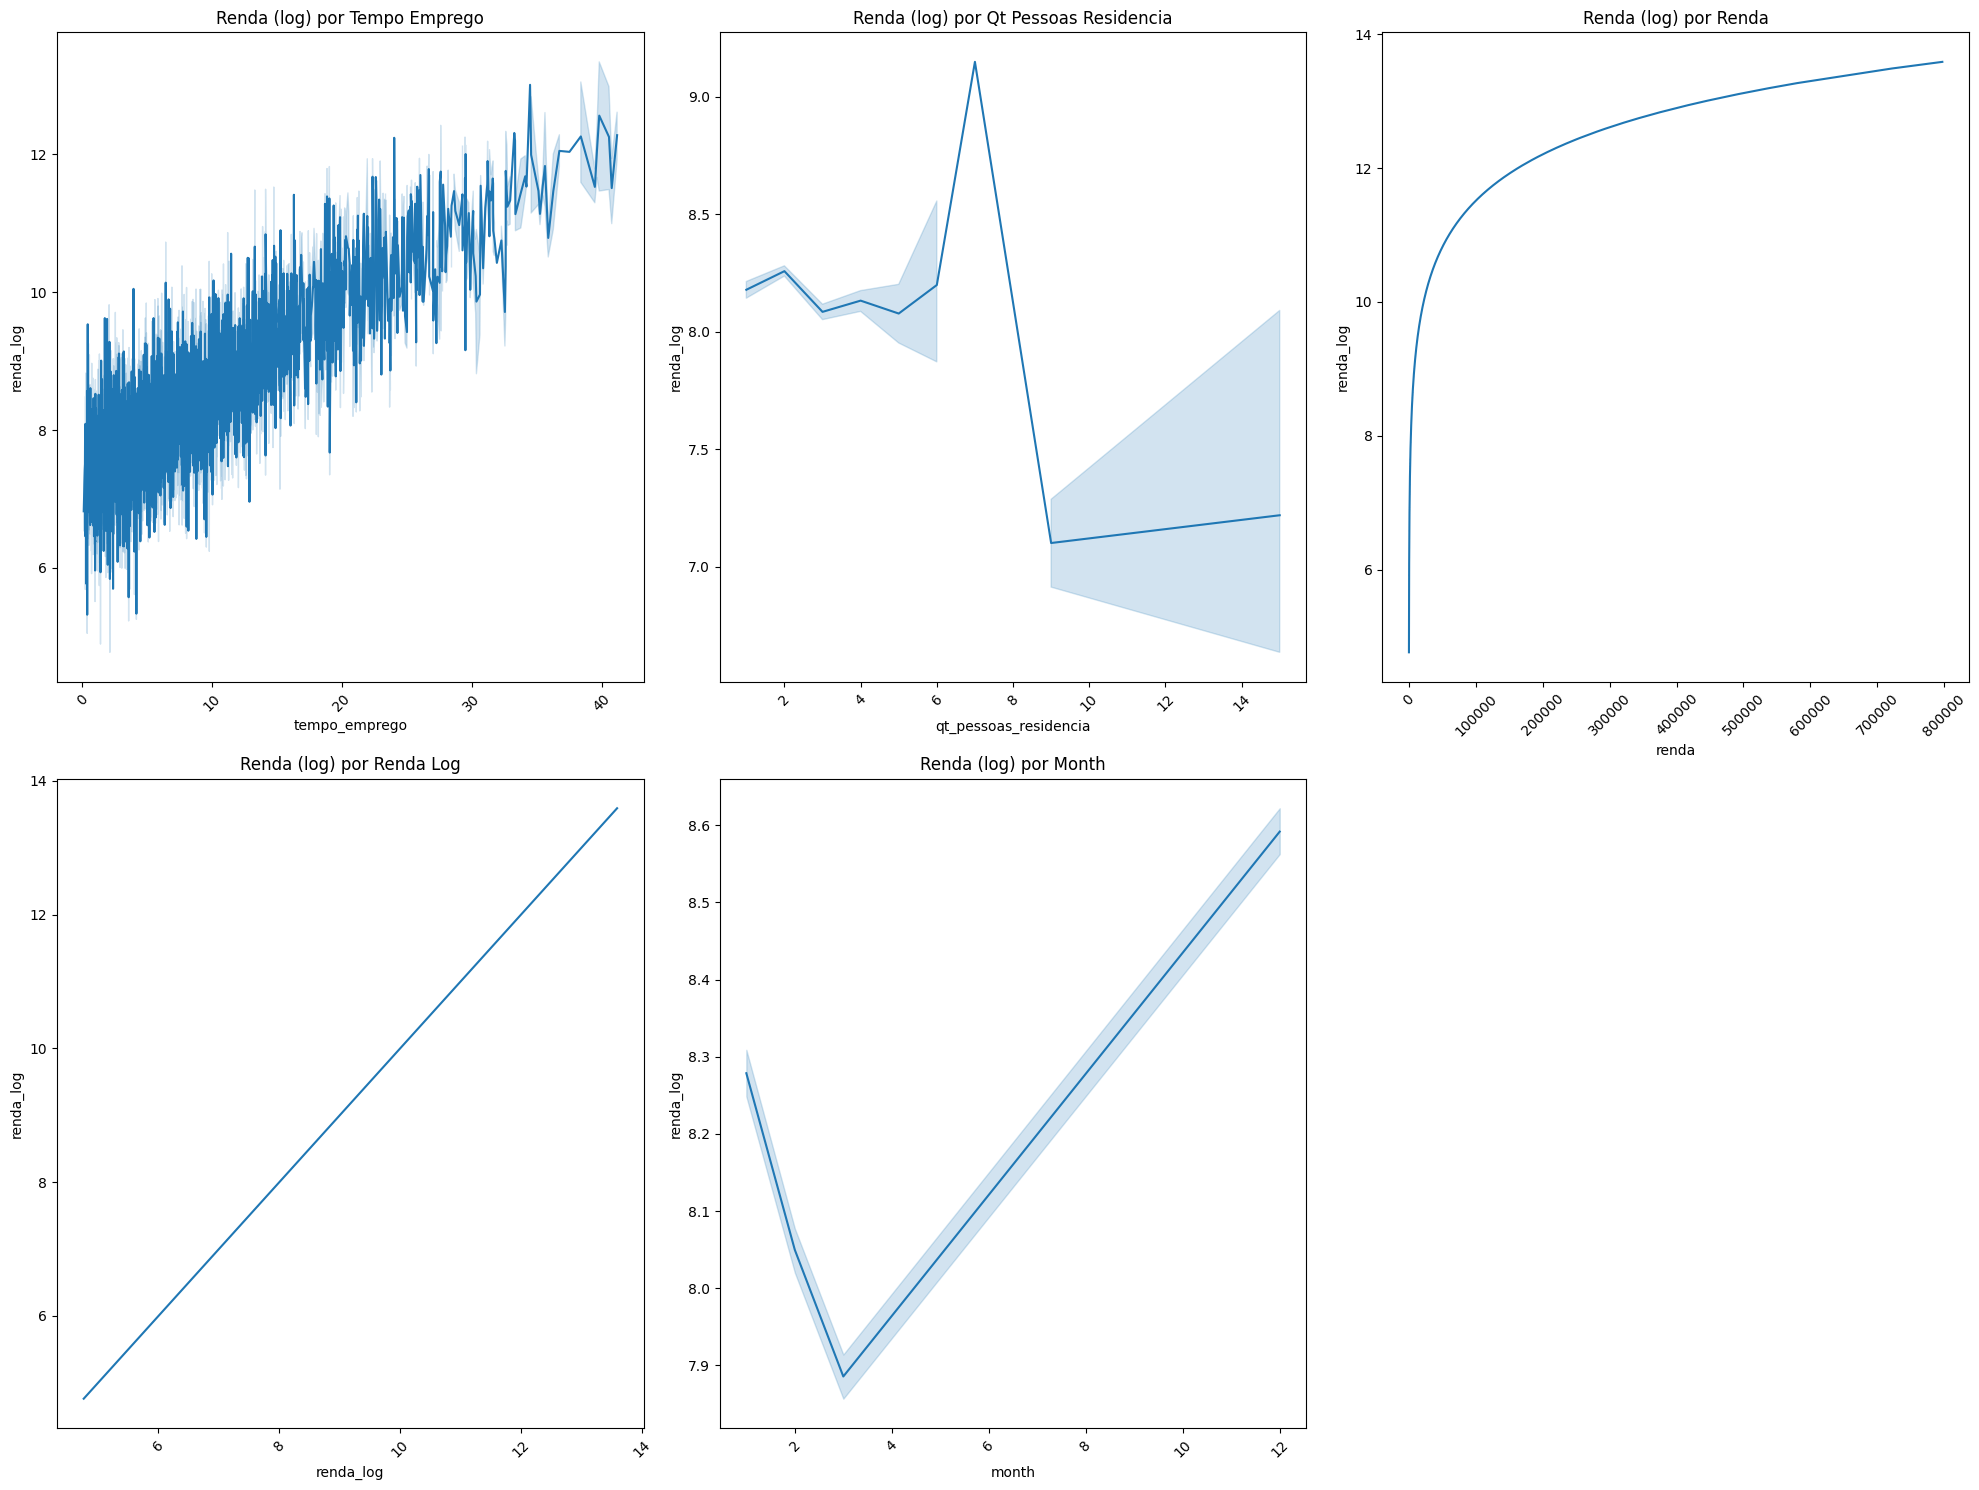

In [ ]:
# Análise univariáda de variáveis numéricas, base validação
fig, ax = plt.subplots(2, 3, figsize=(20,15))
for k, v in enumerate(df_train.select_dtypes(["float64","int32"]).dtypes.index):
    g = sns.lineplot(
        x=v,
        y='renda_log',
        data=df_valid.replace([np.inf, -np.inf], np.nan),
        ax=ax[ax_index[k][0], ax_index[k][1]]
    )
    g.set(title=f"Renda (log) por {v.title().replace('_', ' ')}")
    for item in g.get_xticklabels():
        item.set_rotation(45)
    plt.tight_layout()
ax[1,2].set_axis_off()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

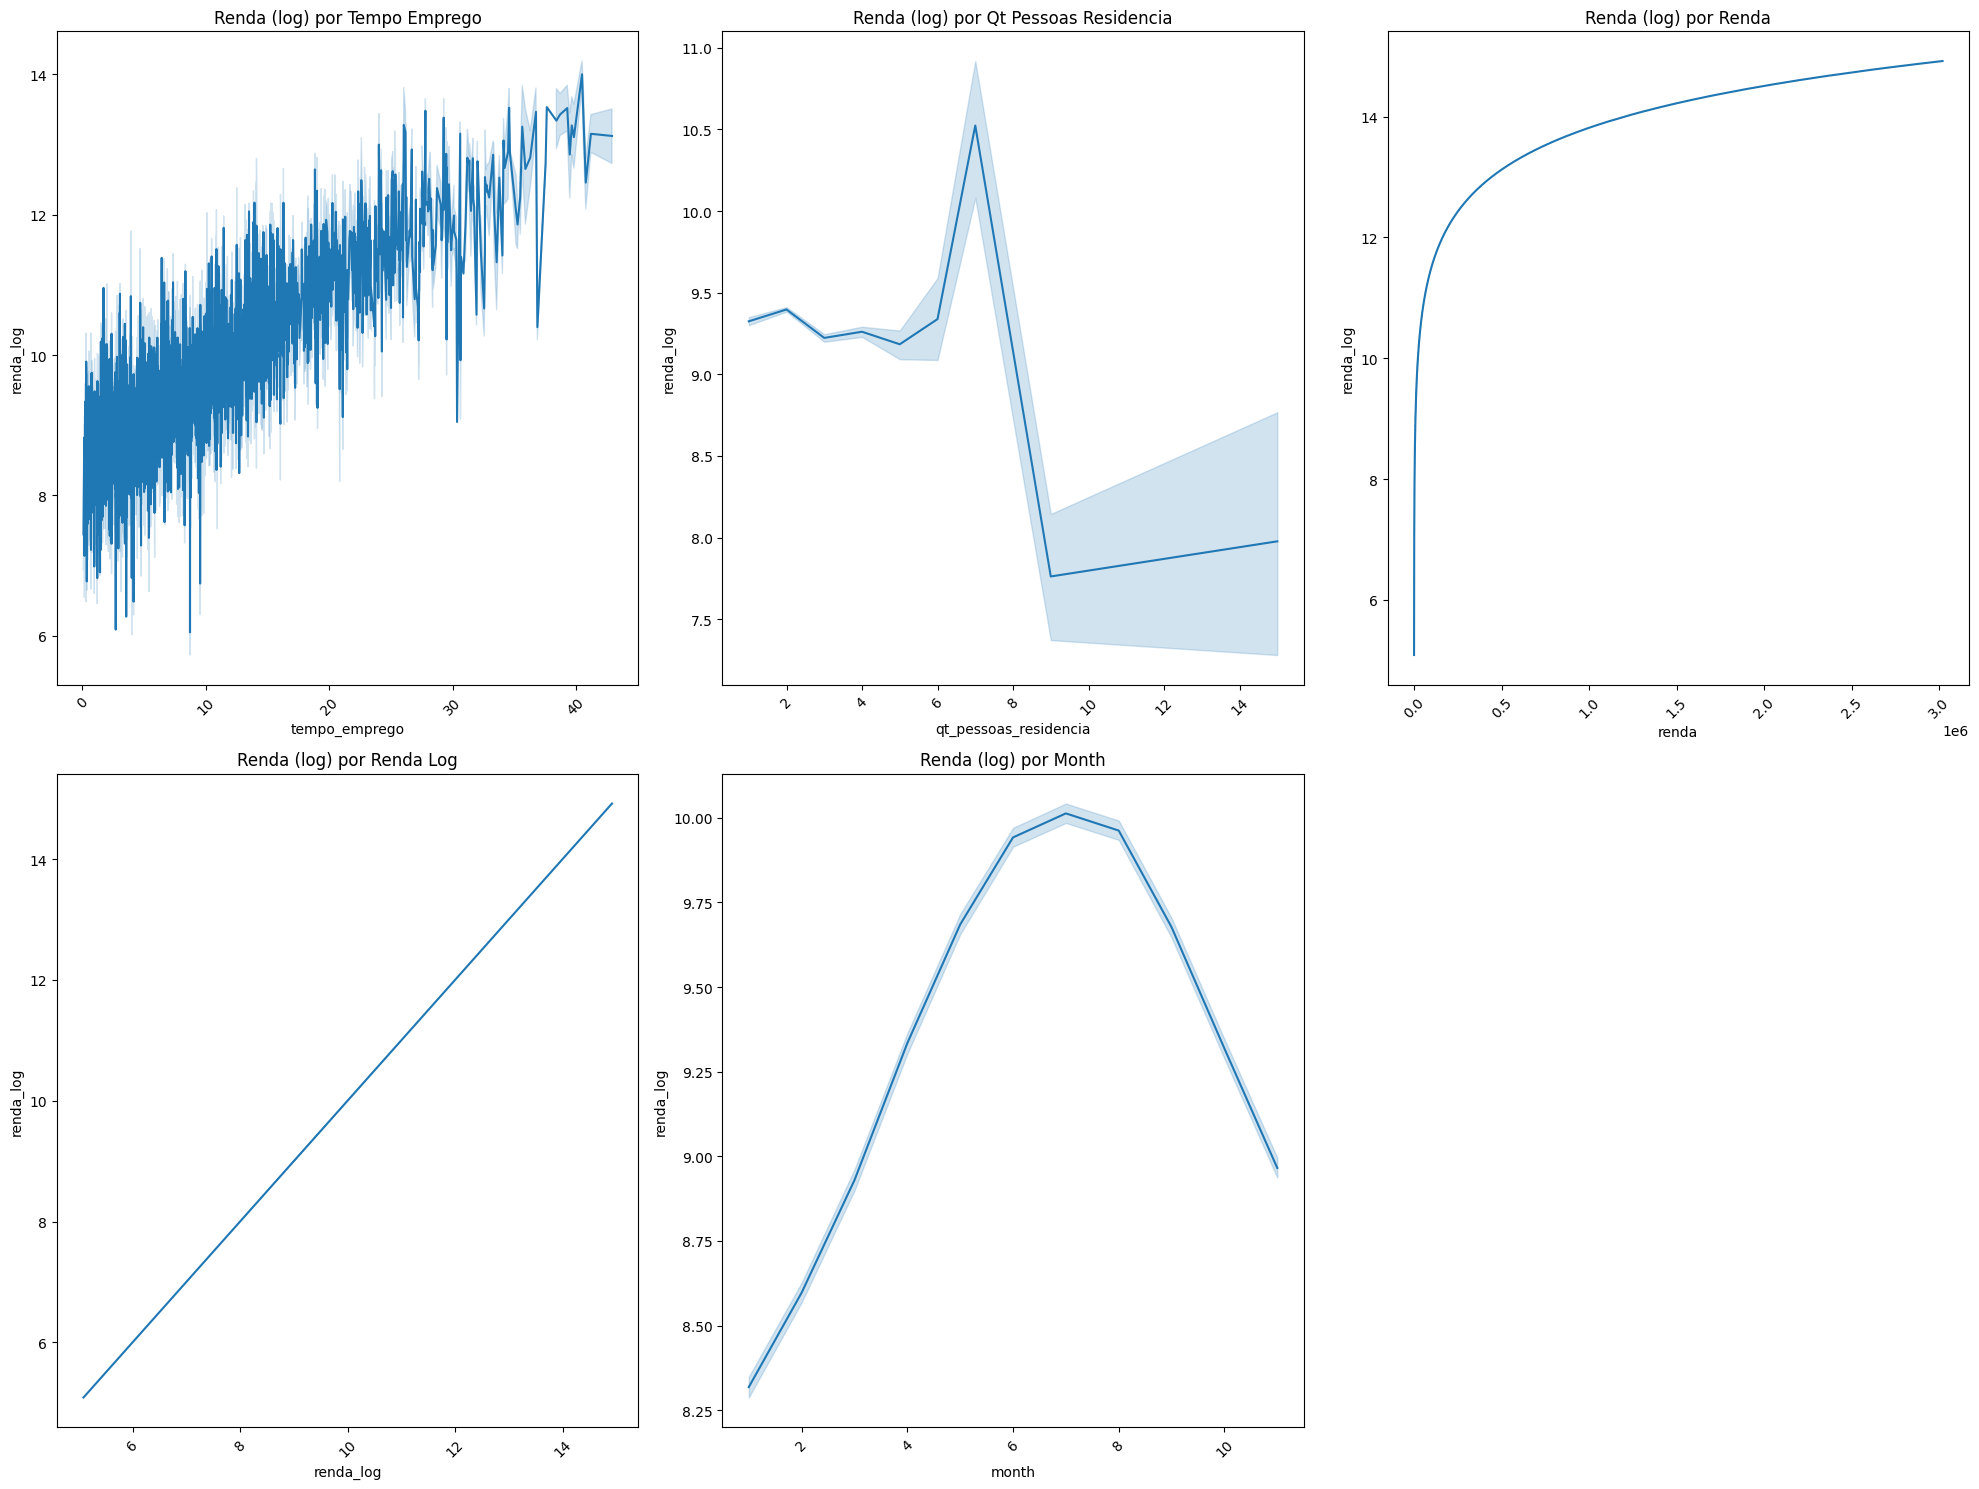

In [ ]:
# Análise univariáda de variáveis numéricas, base treino
fig, ax = plt.subplots(2, 3, figsize=(20,15))
for k, v in enumerate(df_train.select_dtypes(["float64","int32"]).dtypes.index):
    g = sns.lineplot(
        x=v,
        y='renda_log',
        data=df_train.replace([np.inf, -np.inf], np.nan),
        ax=ax[ax_index[k][0], ax_index[k][1]]
    )
    g.set(title=f"Renda (log) por {v.title().replace('_', ' ')}")
    for item in g.get_xticklabels():
        item.set_rotation(45)
    plt.tight_layout()
ax[1,2].set_axis_off()
plt.show

## Conclusão
- Observa-se que todas as analises univariadass retornam informações que podem ser consideradas consistentes para a distribuição de valores em relação a variável resposta

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

In [ ]:
# Função de gráfico e calculos WOE
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(),
                        var: g['mau'].mean().index,
                        'cont':g[var].count()})

    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep

    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    _, ax = plt.subplots(2,1, figsize=(20, 8))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')

    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)

    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)

    ax[1] = biv.cont.plot.bar()
    return biv

In [ ]:
# Variáveis categóricas da base
categorias = df_train.select_dtypes("object").dtypes.index
categorias

Index(['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao',
       'estado_civil', 'tipo_residencia'],
      dtype='object')

#### Base Teste

C:\Users\gfsil\AppData\Local\Temp\ipykernel_29028\1449846887.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,sexo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
sexo,,,,,,,,,,,,,,
F,34751,2215,0.059920,F,36966,0.001234,0.062339,0.05750,-2.752956,-2.710794,-2.796743,0.055203,0.097365,0.011416
M,17159,916,0.050678,M,18075,0.001631,0.053876,0.04748,-2.930262,-2.865697,-2.998804,-0.122103,-0.057538,-0.190645


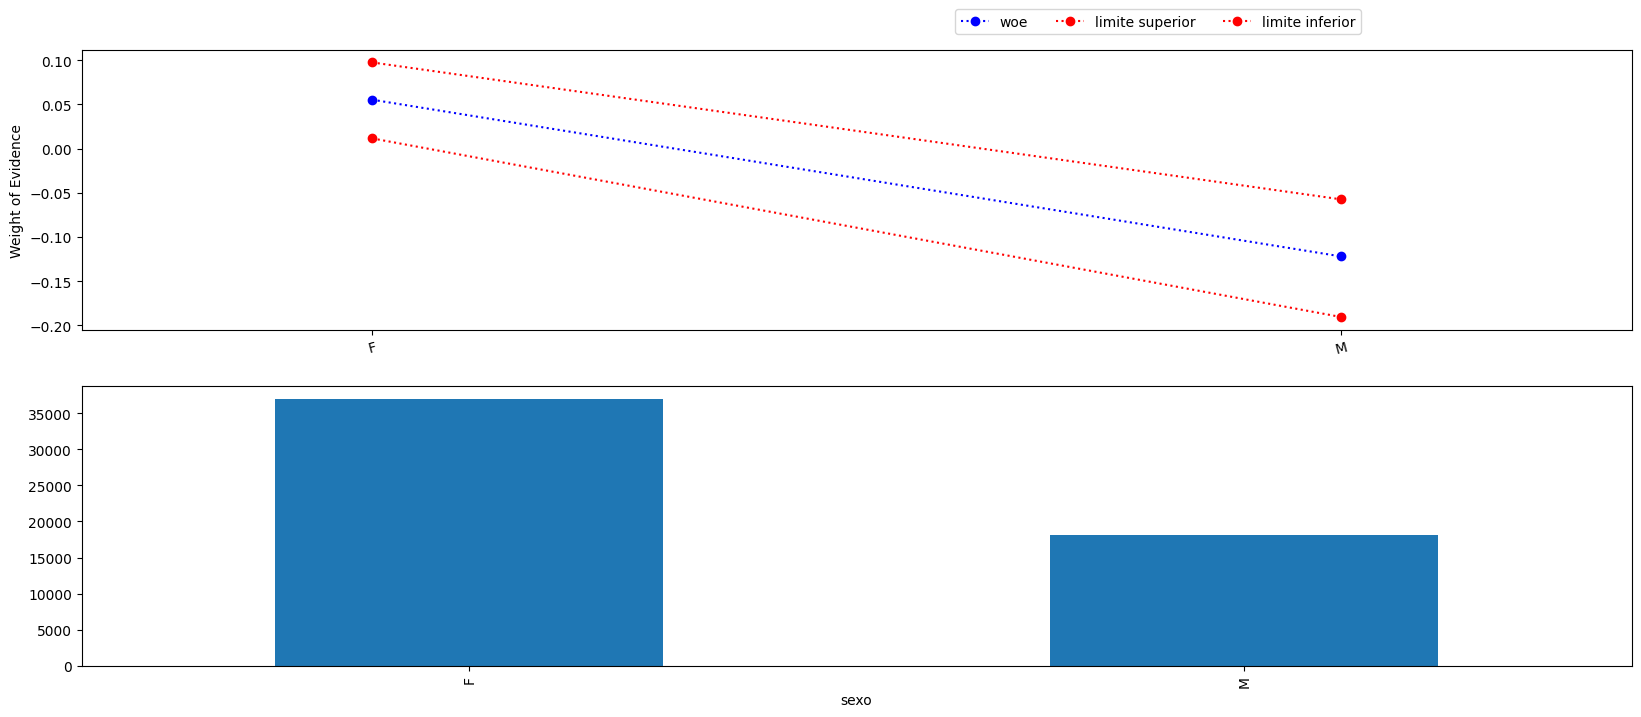

In [ ]:
# Sexo
c = 0
biv_discreta(var=categorias[c], df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_29028\1449846887.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,posse_de_veiculo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_veiculo,,,,,,,,,,,,,,
N,31518,1980,0.059108,N,33498,0.001288,0.061634,0.056583,-2.767462,-2.722935,-2.813809,0.040697,0.085224,-0.005650
S,20392,1151,0.053428,S,21543,0.001532,0.056431,0.050425,-2.874512,-2.816647,-2.935531,-0.066353,-0.008488,-0.127372


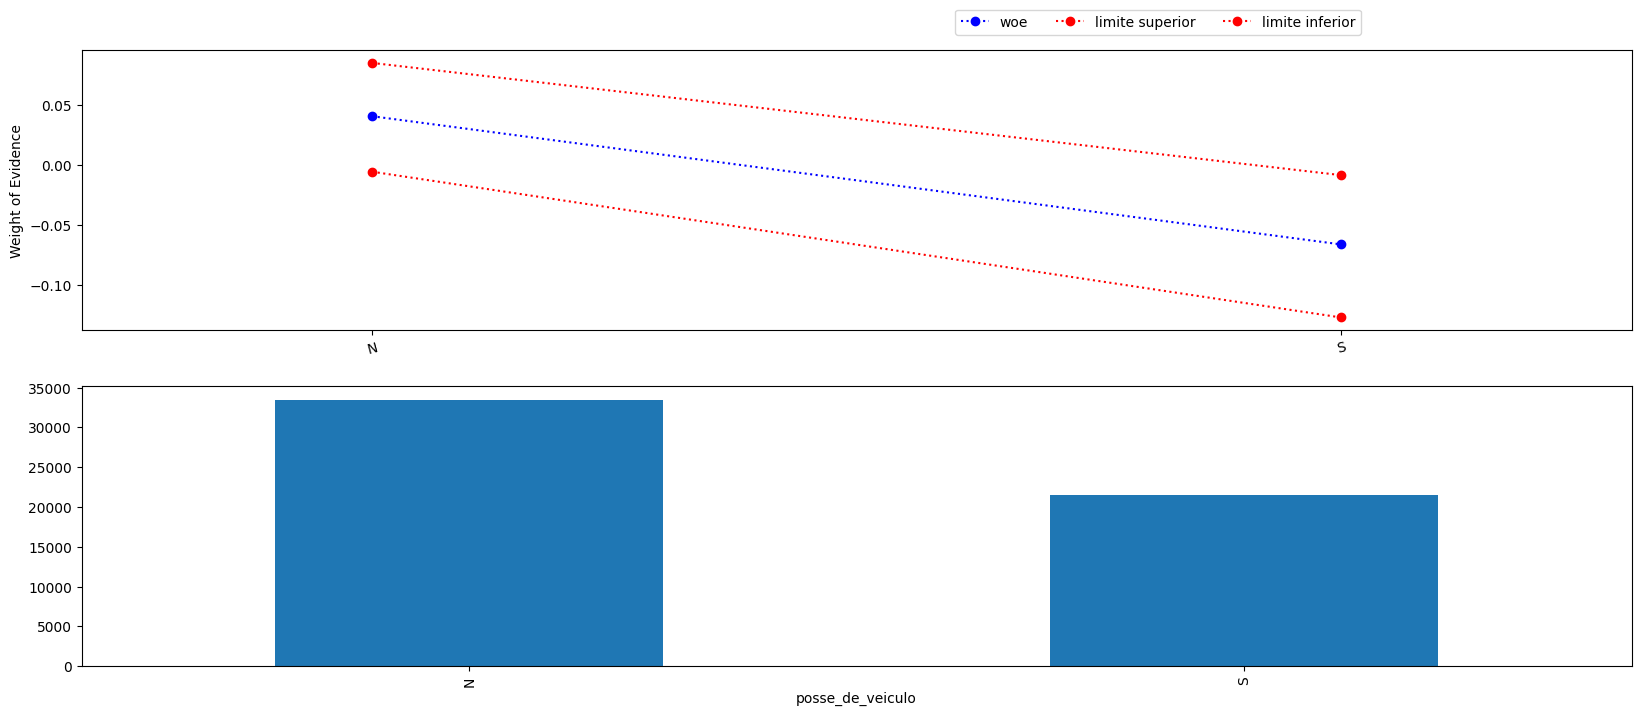

In [ ]:
# Posse De Veículo
c += 1
biv_discreta(var=categorias[c], df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_29028\1449846887.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,posse_de_imovel,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_imovel,,,,,,,,,,,,,,
N,16820,1148,0.063891,N,17968,0.001824,0.067467,0.060315,-2.684547,-2.626258,-2.745960,0.123612,0.181901,0.062199
S,35090,1983,0.053489,S,37073,0.001169,0.055780,0.051199,-2.873305,-2.828952,-2.919488,-0.065146,-0.020793,-0.111329


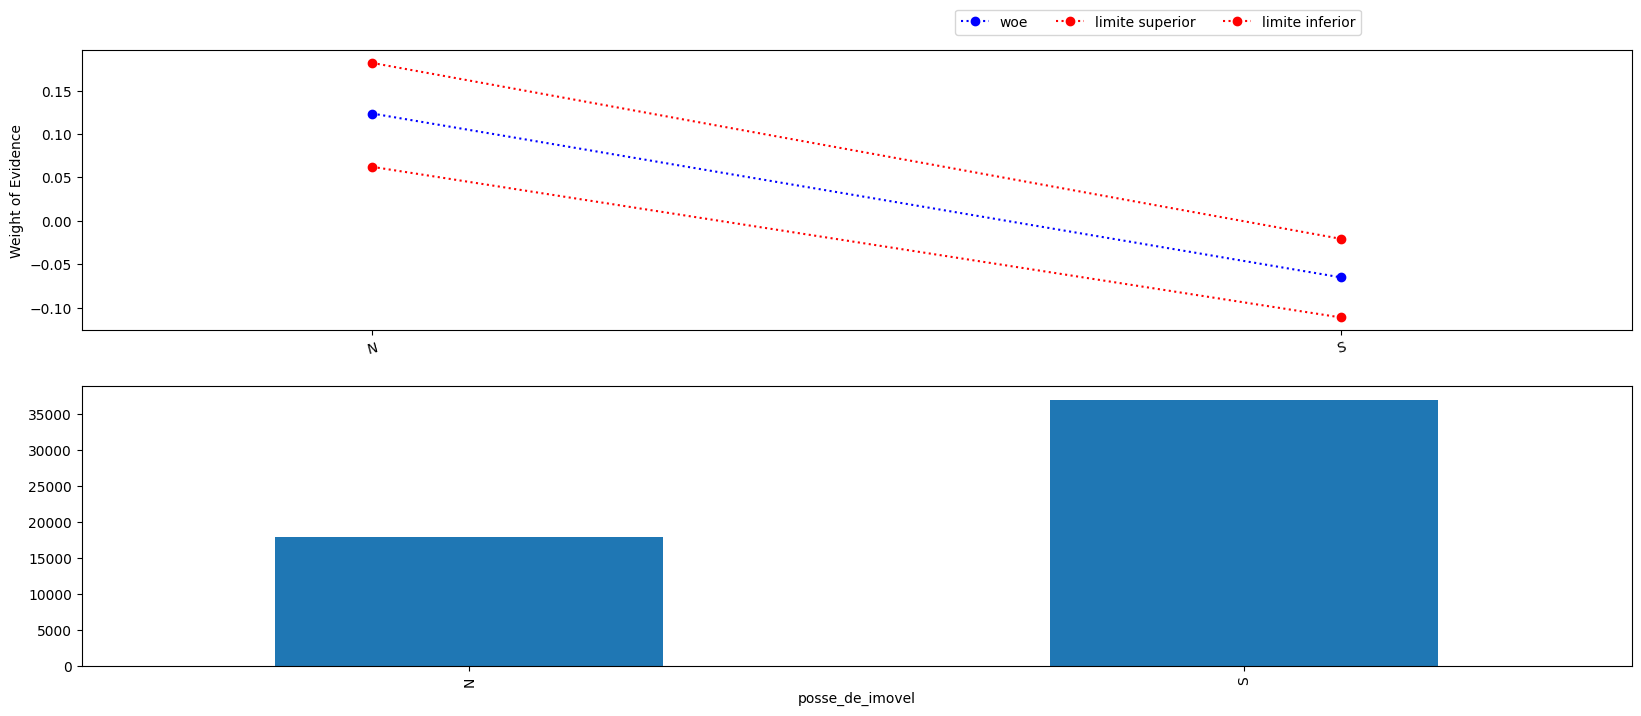

In [ ]:
# Posse De Imóvel
c += 1
biv_discreta(var=categorias[c], df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_29028\1449846887.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,26775,1670,0.058710,Assalariado,28445,0.001394,0.061442,0.055978,-2.774645,-2.726255,-2.825195,0.033514,0.081904,-0.017036
Bolsista,29,1,0.033333,Bolsista,30,0.032773,0.100362,-0.033695,-3.367296,-2.193211,NaN,-0.559137,0.614948,NaN
Empresário,11940,674,0.053433,Empresário,12614,0.002002,0.057358,0.049508,-2.874419,-2.799379,-2.954853,-0.066260,0.008780,-0.146694
Pensionista,8579,597,0.065061,Pensionista,9176,0.002575,0.070108,0.060014,-2.665156,-2.585032,-2.751286,0.143003,0.223127,0.056873
Servidor público,4587,189,0.039573,Servidor público,4776,0.002821,0.045103,0.034042,-3.189234,-3.052648,-3.345511,-0.381075,-0.244489,-0.537352


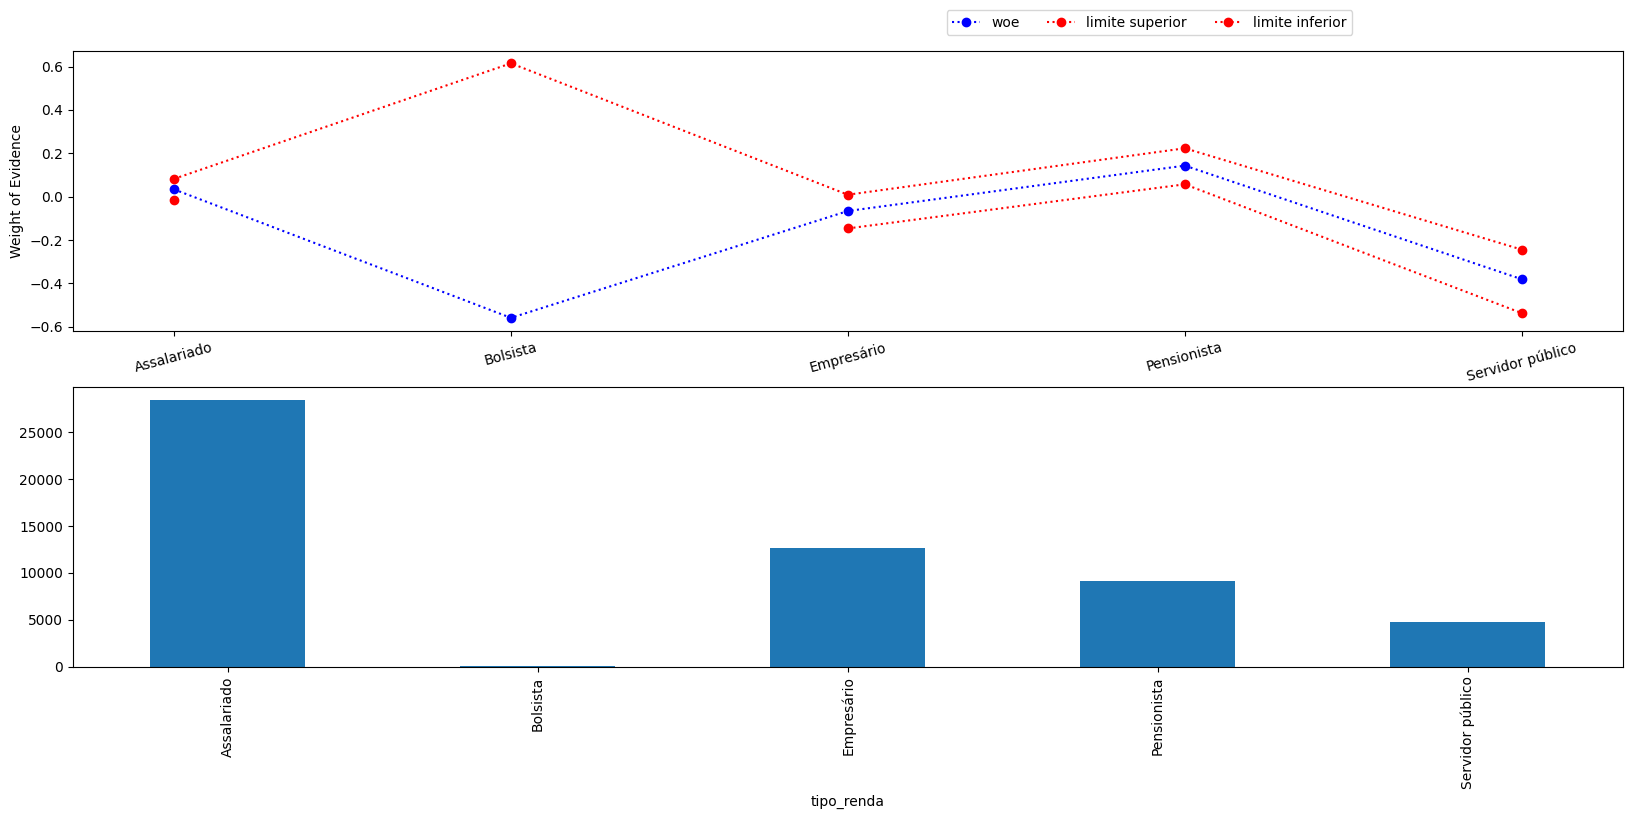

In [ ]:
# Tipo Renda
c += 1
biv_discreta(var=categorias[c], df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_29028\1449846887.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental,589,40,0.063593,Fundamental,629,0.009730,0.082700,0.044486,-2.689547,-2.406212,-3.067080,0.118612,0.401947,-0.258921
Médio,35075,2223,0.059601,Médio,37298,0.001226,0.062004,0.057198,-2.758631,-2.716551,-2.802331,0.049528,0.091608,0.005828
Pós graduação,62,3,0.046154,Pós graduação,65,0.026025,0.098144,-0.005837,-3.028522,-2.218016,NaN,-0.220363,0.590143,NaN
Superior completo,14111,737,0.049636,Superior completo,14848,0.001782,0.053130,0.046143,-2.952122,-2.880418,-3.028779,-0.143963,-0.072259,-0.220620
Superior incompleto,2073,128,0.058155,Superior incompleto,2201,0.004989,0.067938,0.048373,-2.784722,-2.618801,-2.979240,0.023437,0.189358,-0.171081


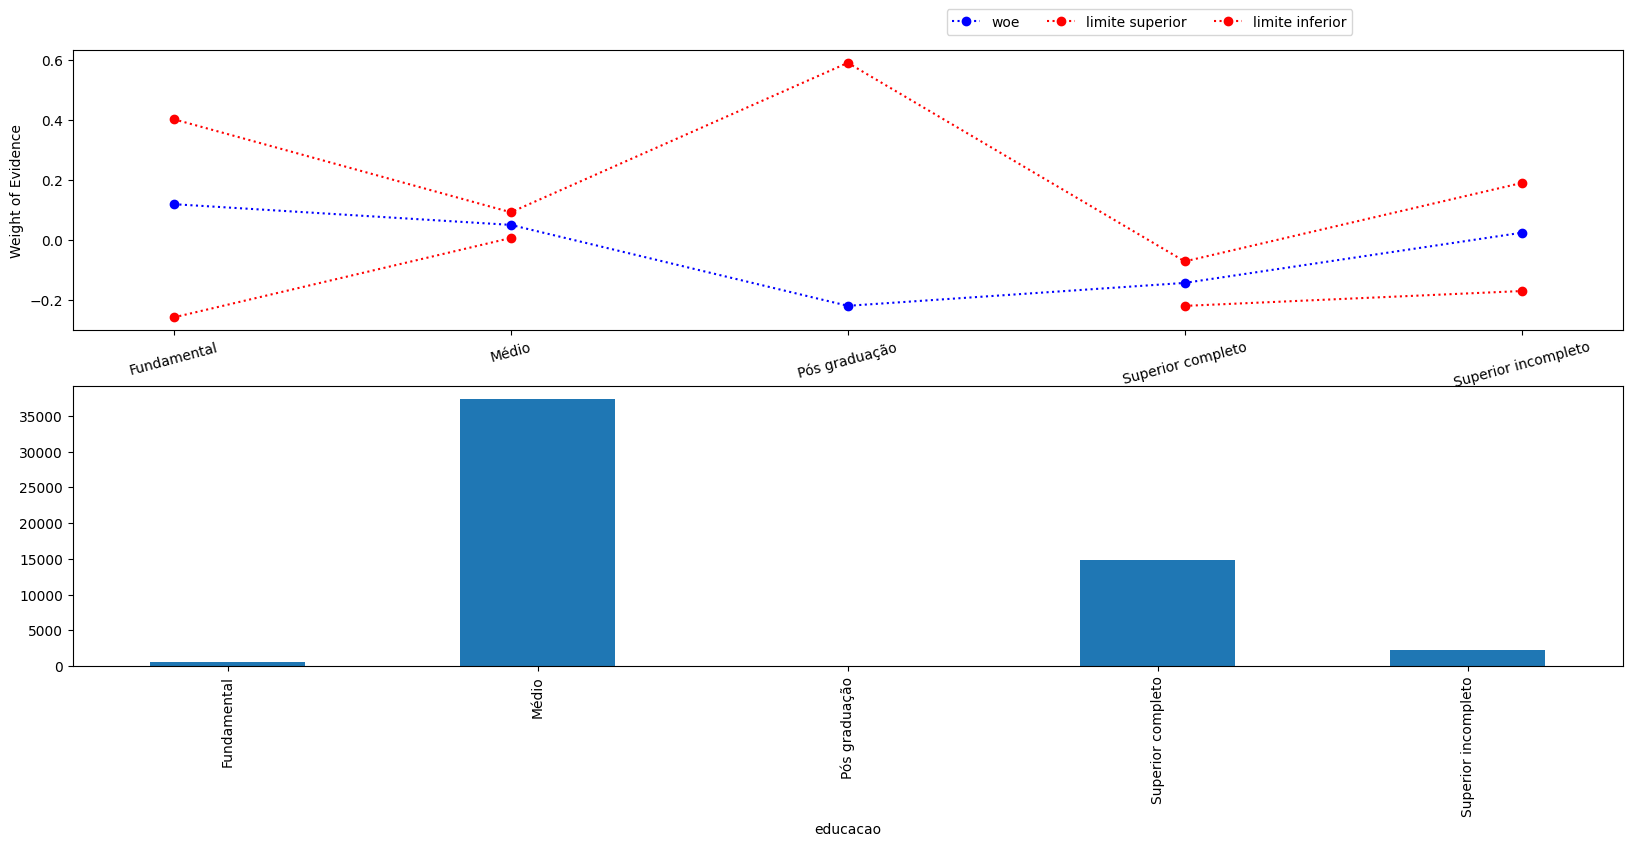

In [ ]:
# Educação
c += 1
biv_discreta(var=categorias[c], df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_29028\1449846887.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,estado_civil,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
estado_civil,,,,,,,,,,,,,,
Casado,36649,2173,0.055973,Casado,38822,0.001167,0.058260,0.053687,-2.825277,-2.782812,-2.869408,-0.017118,0.025347,-0.061249
Separado,2904,178,0.057755,Separado,3082,0.004202,0.065994,0.049516,-2.792061,-2.649923,-2.954683,0.016098,0.158236,-0.146524
Solteiro,6197,397,0.060206,Solteiro,6594,0.002929,0.065949,0.054464,-2.747884,-2.650656,-2.854214,0.060275,0.157503,-0.046055
União,3971,240,0.056994,União,4211,0.003573,0.063998,0.049990,-2.806134,-2.682771,-2.944660,0.002025,0.125388,-0.136501
Viúvo,2189,143,0.061321,Viúvo,2332,0.004968,0.071063,0.051578,-2.728355,-2.570470,-2.911700,0.079804,0.237689,-0.103541


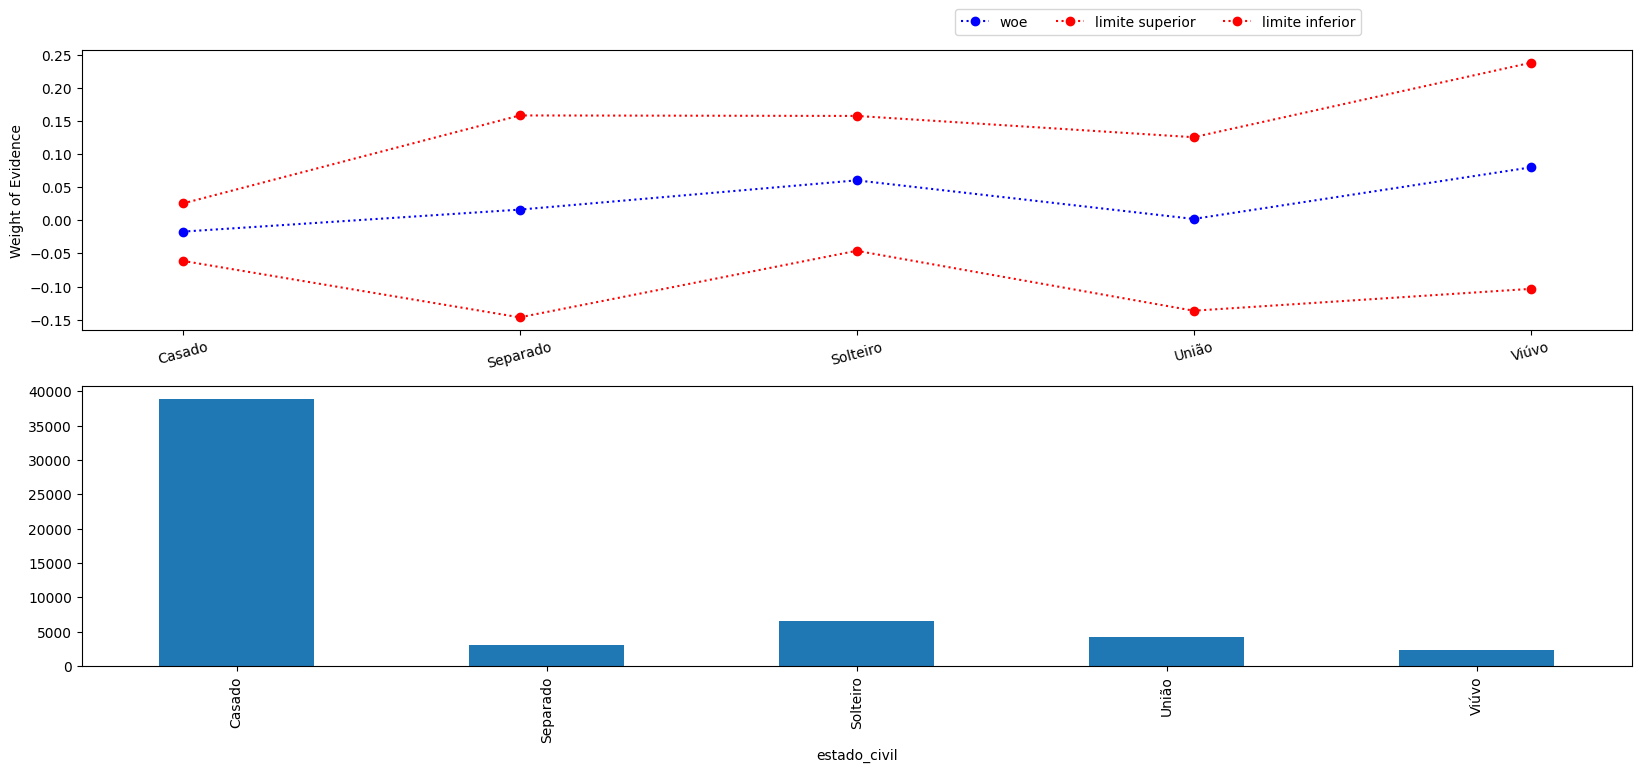

In [ ]:
# Estado Civil
c += 1
biv_discreta(var=categorias[c], df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_29028\1449846887.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,tipo_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_residencia,,,,,,,,,,,,,,
Aluguel,705,49,0.064987,Aluguel,754,0.008977,0.082610,0.047364,-2.666378,-2.407404,-3.001378,0.141782,0.400755,-0.193219
Casa,46759,2794,0.056384,Casa,49553,0.001036,0.058415,0.054353,-2.817532,-2.779991,-2.856367,-0.009373,0.028168,-0.048208
Com os pais,2206,154,0.065254,Com os pais,2360,0.005084,0.075224,0.055285,-2.661984,-2.509087,-2.838383,0.146175,0.299072,-0.030224
Comunitário,239,19,0.073643,Comunitário,258,0.016261,0.105665,0.041622,-2.532025,-2.135806,-3.136620,0.276134,0.672353,-0.328461
Estúdio,377,21,0.052764,Estúdio,398,0.011206,0.074795,0.030733,-2.887723,-2.515270,-3.451202,-0.079564,0.292889,-0.643043
Governamental,1624,94,0.054715,Governamental,1718,0.005487,0.065476,0.043953,-2.849353,-2.658347,-3.079682,-0.041194,0.149812,-0.271523


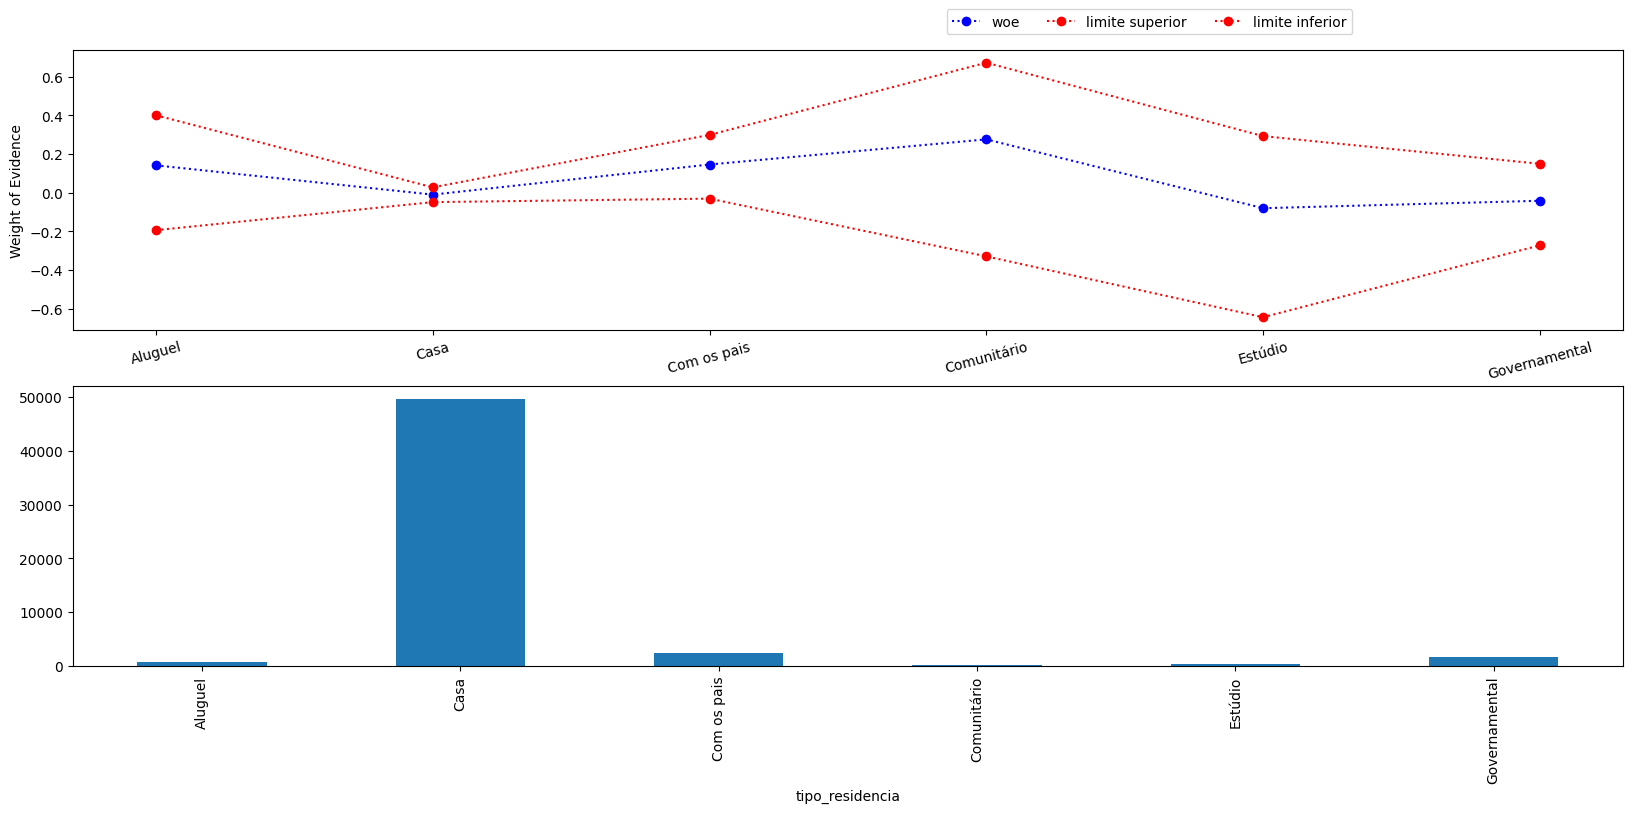

In [ ]:
# Tipo Residência
c += 1
biv_discreta(var=categorias[c], df=df_train)

#### Base Validação

C:\Users\gfsil\AppData\Local\Temp\ipykernel_29028\1449846887.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,sexo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
sexo,,,,,,,,,,,,,,
F,11544,1813,0.135734,F,13357,0.002964,0.141543,0.129925,-1.851183,-1.802532,-1.901621,0.024179,0.072830,-0.026259
M,5762,840,0.127234,M,6602,0.004101,0.135274,0.119194,-1.925638,-1.855111,-2.000081,-0.050276,0.020251,-0.124718


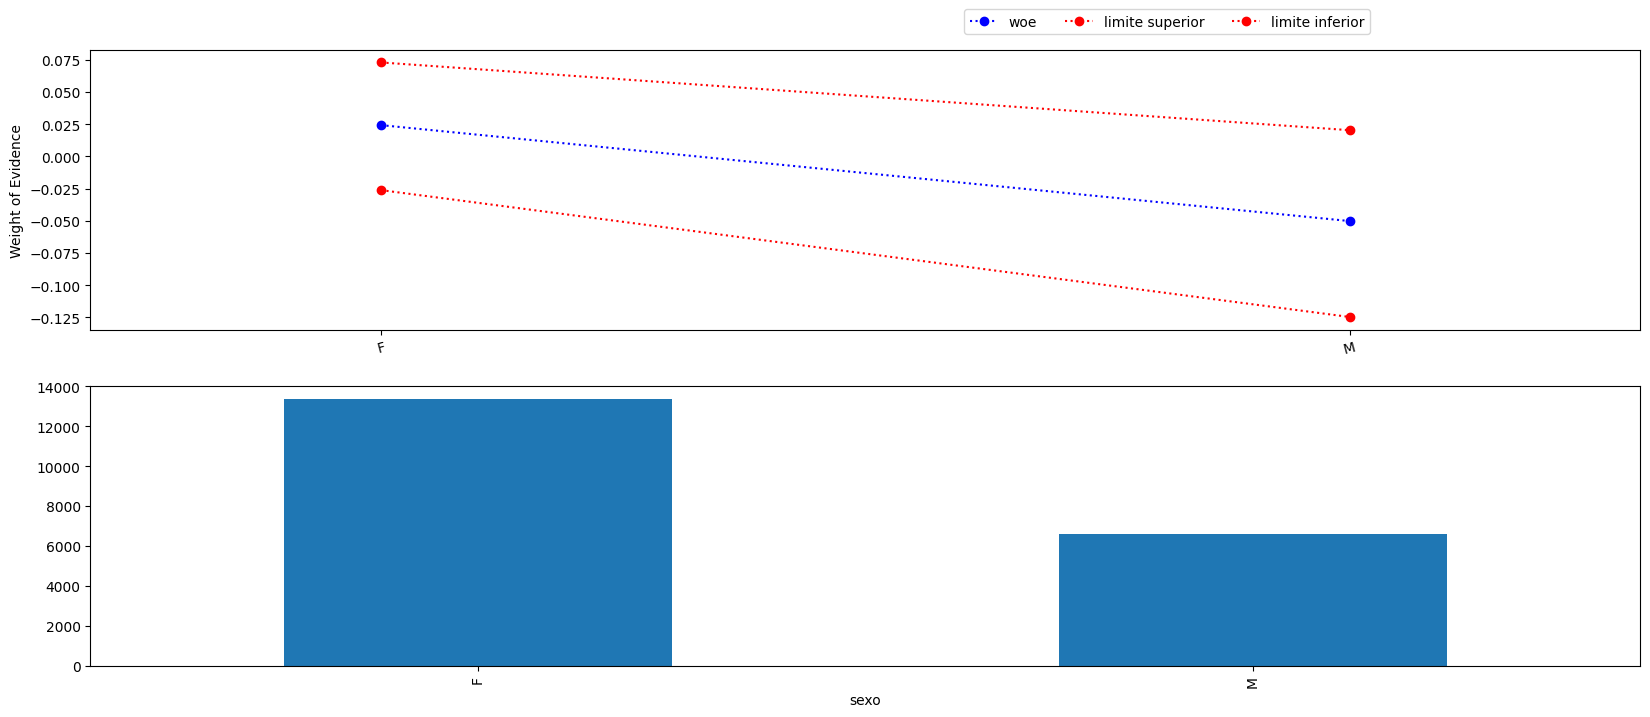

In [ ]:
c = 0
biv_discreta(var=categorias[c], df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_29028\1449846887.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,posse_de_veiculo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_veiculo,,,,,,,,,,,,,,
N,10494,1615,0.133372,N,12109,0.003090,0.139428,0.127316,-1.871469,-1.820050,-1.924902,0.003893,0.055312,-0.049540
S,6812,1038,0.132229,S,7850,0.003823,0.139724,0.124735,-1.881390,-1.817585,-1.948338,-0.006028,0.057777,-0.072975


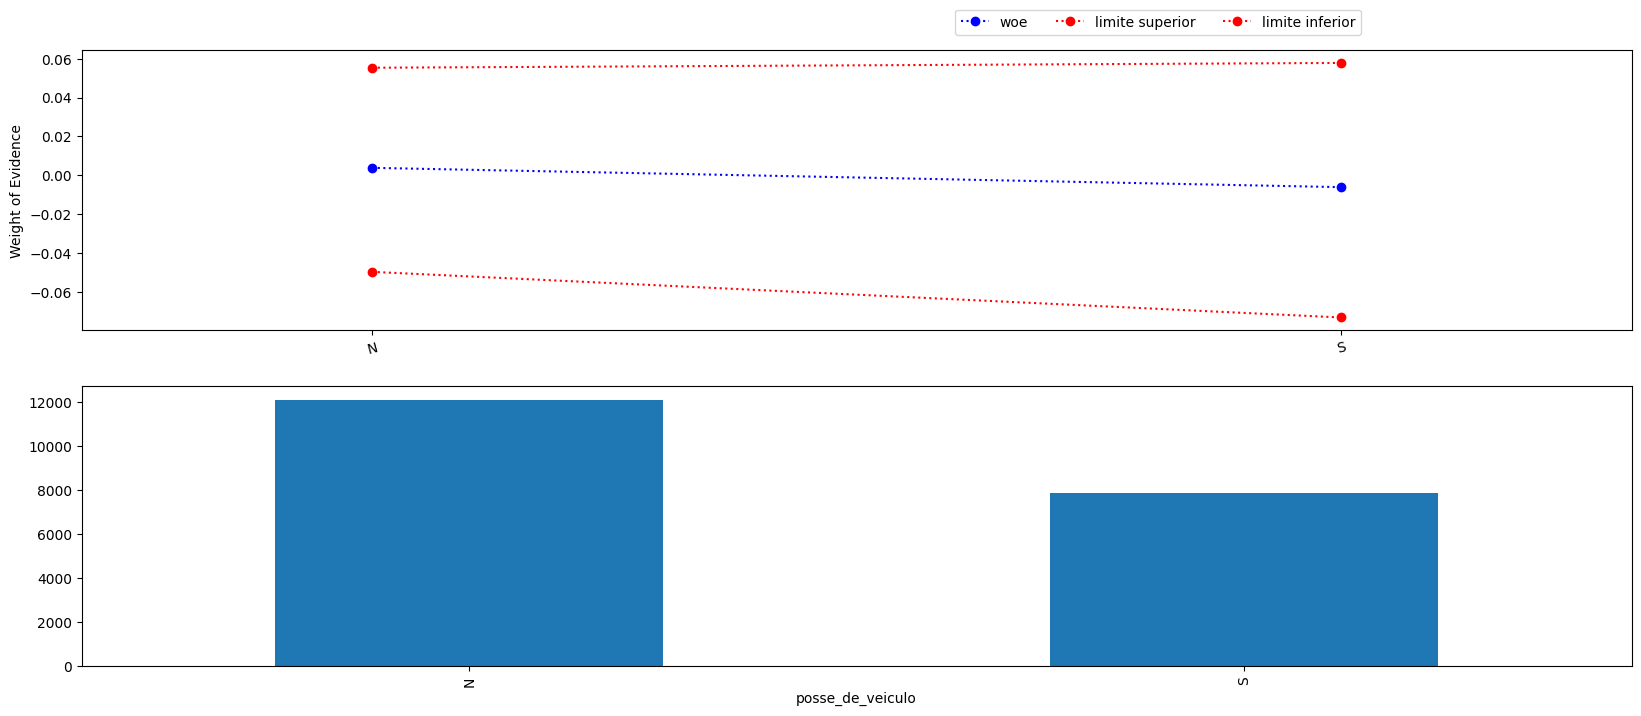

In [ ]:
c += 1
biv_discreta(var=categorias[c], df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_29028\1449846887.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,posse_de_imovel,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_imovel,,,,,,,,,,,,,,
N,5662,983,0.147931,N,6645,0.004355,0.156469,0.139393,-1.750923,-1.684742,-1.820341,0.124439,0.190620,0.055021
S,11644,1670,0.125432,S,13314,0.002870,0.131058,0.119805,-1.941967,-1.891634,-1.994274,-0.066605,-0.016271,-0.118912


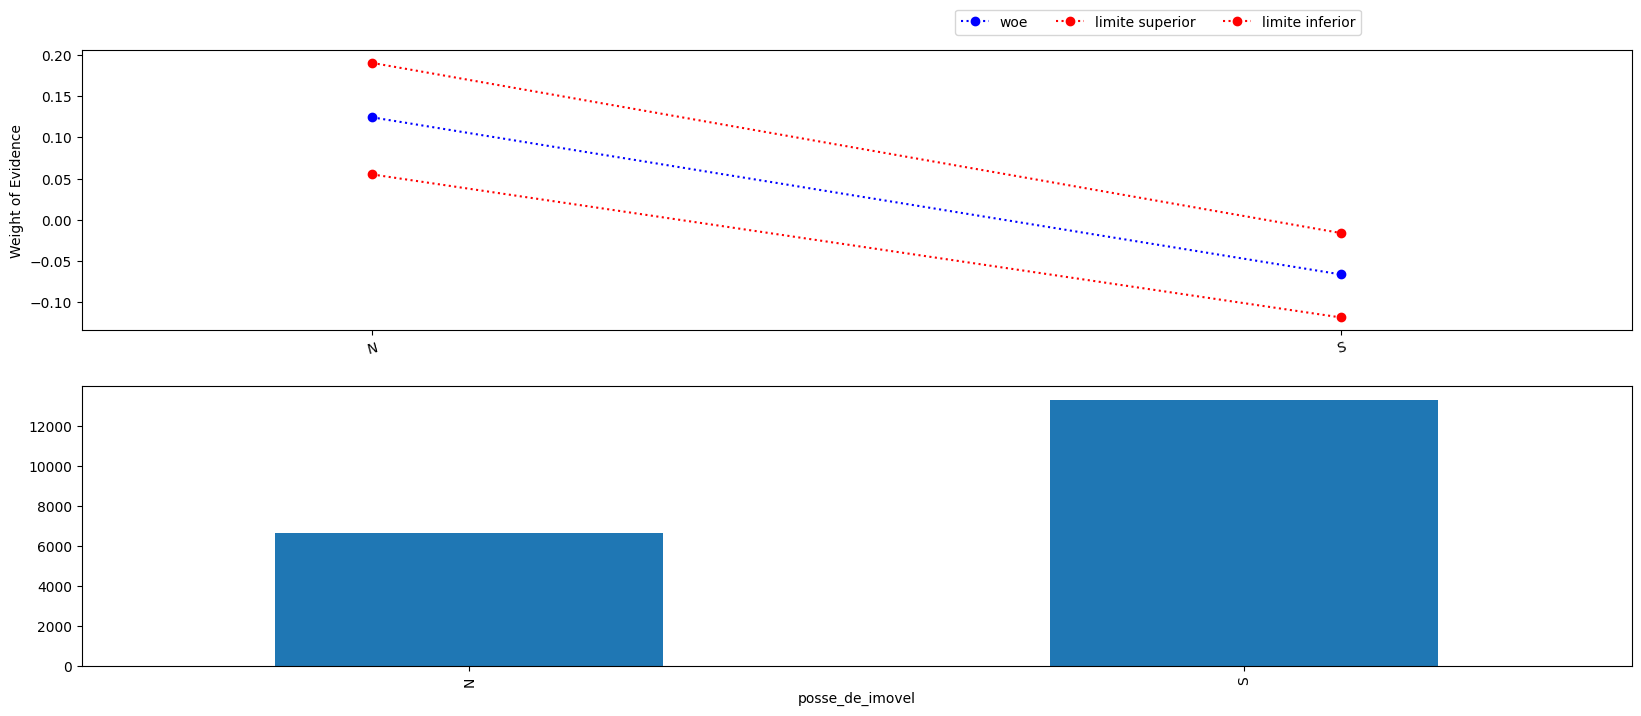

In [ ]:
c += 1
biv_discreta(var=categorias[c], df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_29028\1449846887.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,8946,1378,0.133475,Assalariado,10324,0.003347,0.140036,0.126914,-1.870573,-1.814988,-1.928520,0.004789,0.060374,-0.053158
Bolsista,12,1,0.076923,Bolsista,13,0.073905,0.237949,-0.084103,-2.484907,-1.163958,NaN,-0.609544,0.711404,NaN
Empresário,4076,587,0.125885,Empresário,4663,0.004858,0.135408,0.116361,-1.937847,-1.853964,-2.027350,-0.062484,0.021398,-0.151988
Pensionista,2787,513,0.155455,Pensionista,3300,0.006307,0.167822,0.143088,-1.692445,-1.601146,-1.789879,0.182917,0.274216,0.085483
Servidor público,1485,174,0.104882,Servidor público,1659,0.007523,0.119637,0.090128,-2.144115,-1.995870,-2.312077,-0.268753,-0.120507,-0.436715


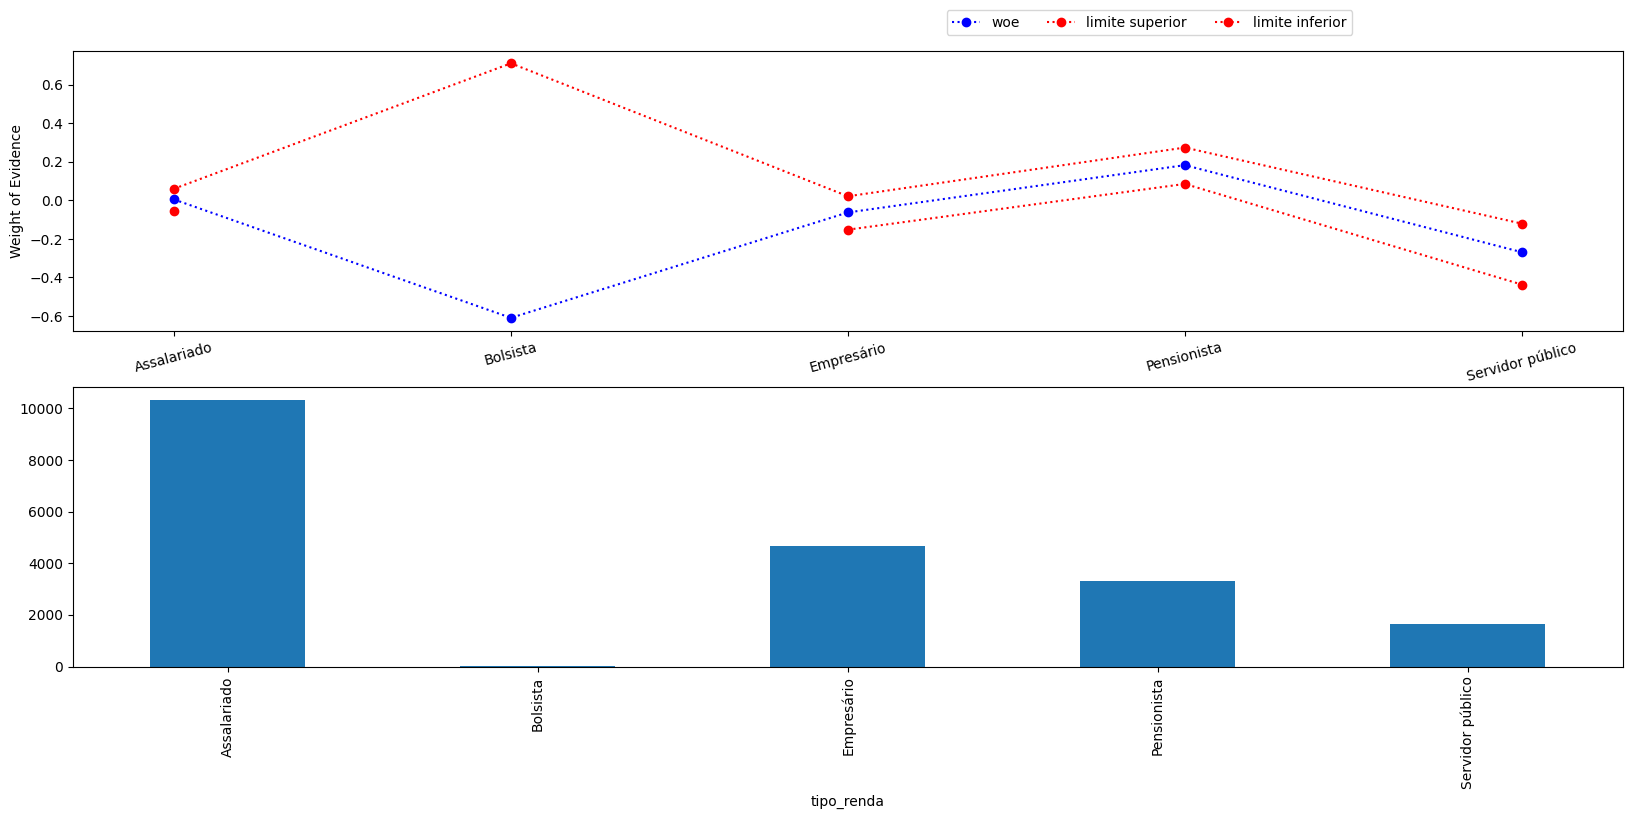

In [ ]:
c += 1
biv_discreta(var=categorias[c], df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_29028\1449846887.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental,205,42,0.170040,Fundamental,247,0.023903,0.217122,0.122959,-1.585340,-1.282520,-1.964699,0.290022,0.592842,-0.089337
Médio,11551,1852,0.138178,Médio,13403,0.002981,0.144021,0.132335,-1.830506,-1.782289,-1.880466,0.044856,0.093073,-0.005104
Pós graduação,13,1,0.071429,Pós graduação,14,0.068830,0.220127,-0.077270,-2.564949,-1.264924,NaN,-0.689587,0.610438,NaN
Superior completo,4831,657,0.119716,Superior completo,5488,0.004382,0.128306,0.111125,-1.995125,-1.916017,-2.079300,-0.119763,-0.040655,-0.203937
Superior incompleto,706,101,0.125155,Superior incompleto,807,0.011648,0.148019,0.102291,-1.944495,-1.750224,-2.172026,-0.069133,0.125138,-0.296664


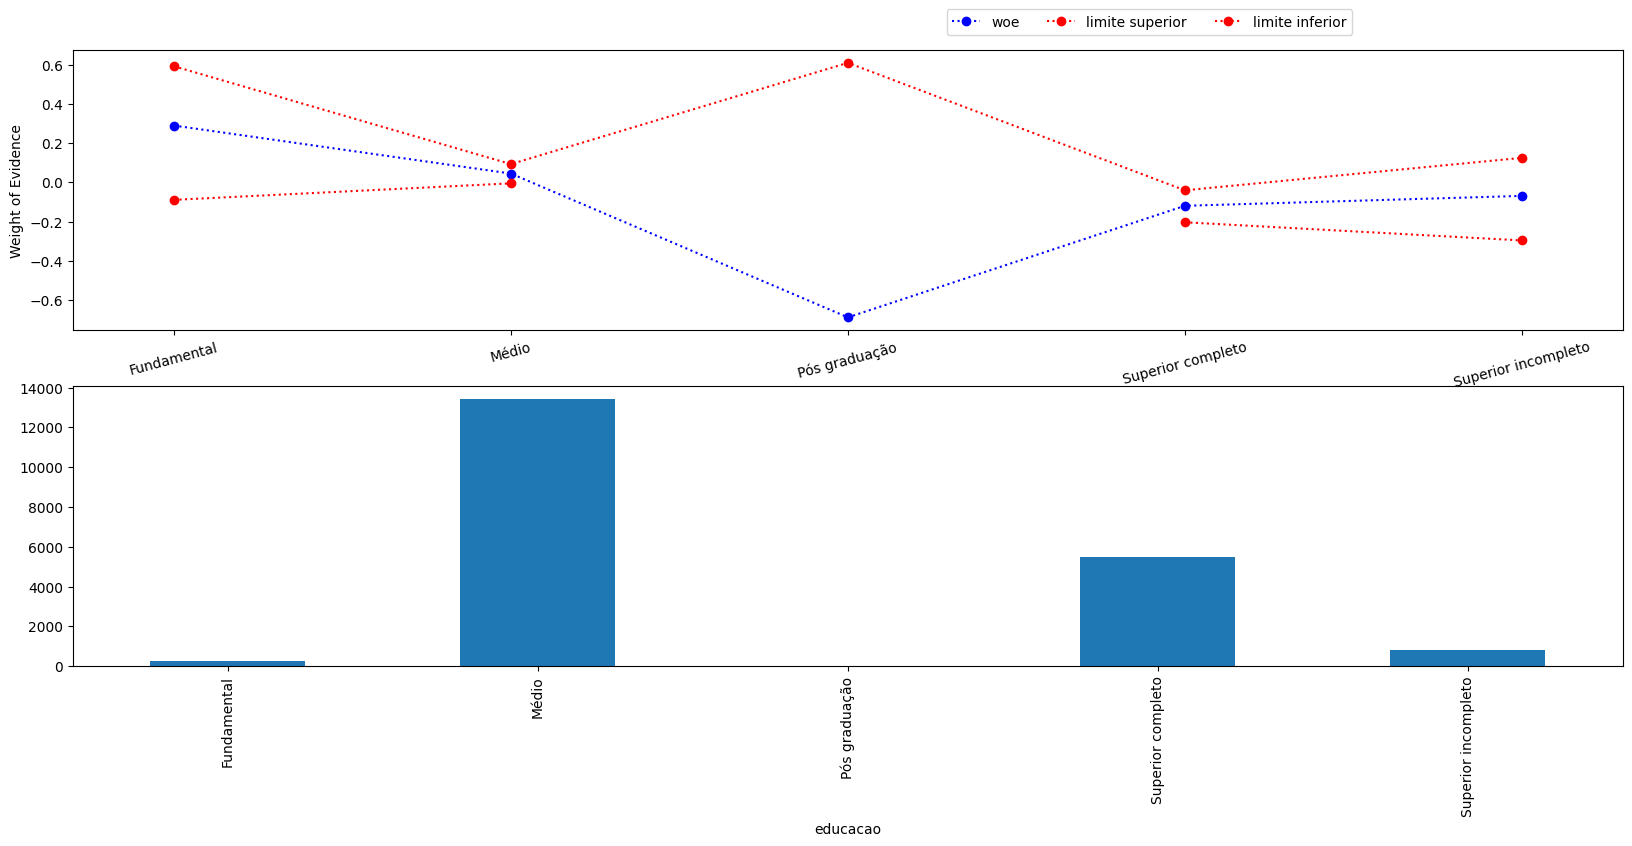

In [ ]:
c += 1
biv_discreta(var=categorias[c], df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_29028\1449846887.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,estado_civil,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
estado_civil,,,,,,,,,,,,,,
Casado,12207,1835,0.130679,Casado,14042,0.002844,0.136255,0.125104,-1.894965,-1.846752,-1.944958,-0.019603,0.028610,-0.069596
Separado,995,146,0.127958,Separado,1141,0.009889,0.147361,0.108555,-1.919136,-1.755451,-2.105588,-0.043774,0.119911,-0.230225
Solteiro,2105,326,0.134101,Solteiro,2431,0.006911,0.147654,0.120549,-1.865173,-1.753123,-1.987245,0.010189,0.122240,-0.111883
União,1275,229,0.152261,União,1504,0.009264,0.170432,0.134089,-1.716979,-1.582565,-1.865280,0.158383,0.292797,0.010082
Viúvo,724,117,0.139120,Viúvo,841,0.011934,0.162543,0.115697,-1.822617,-1.639427,-2.033824,0.052745,0.235936,-0.158462


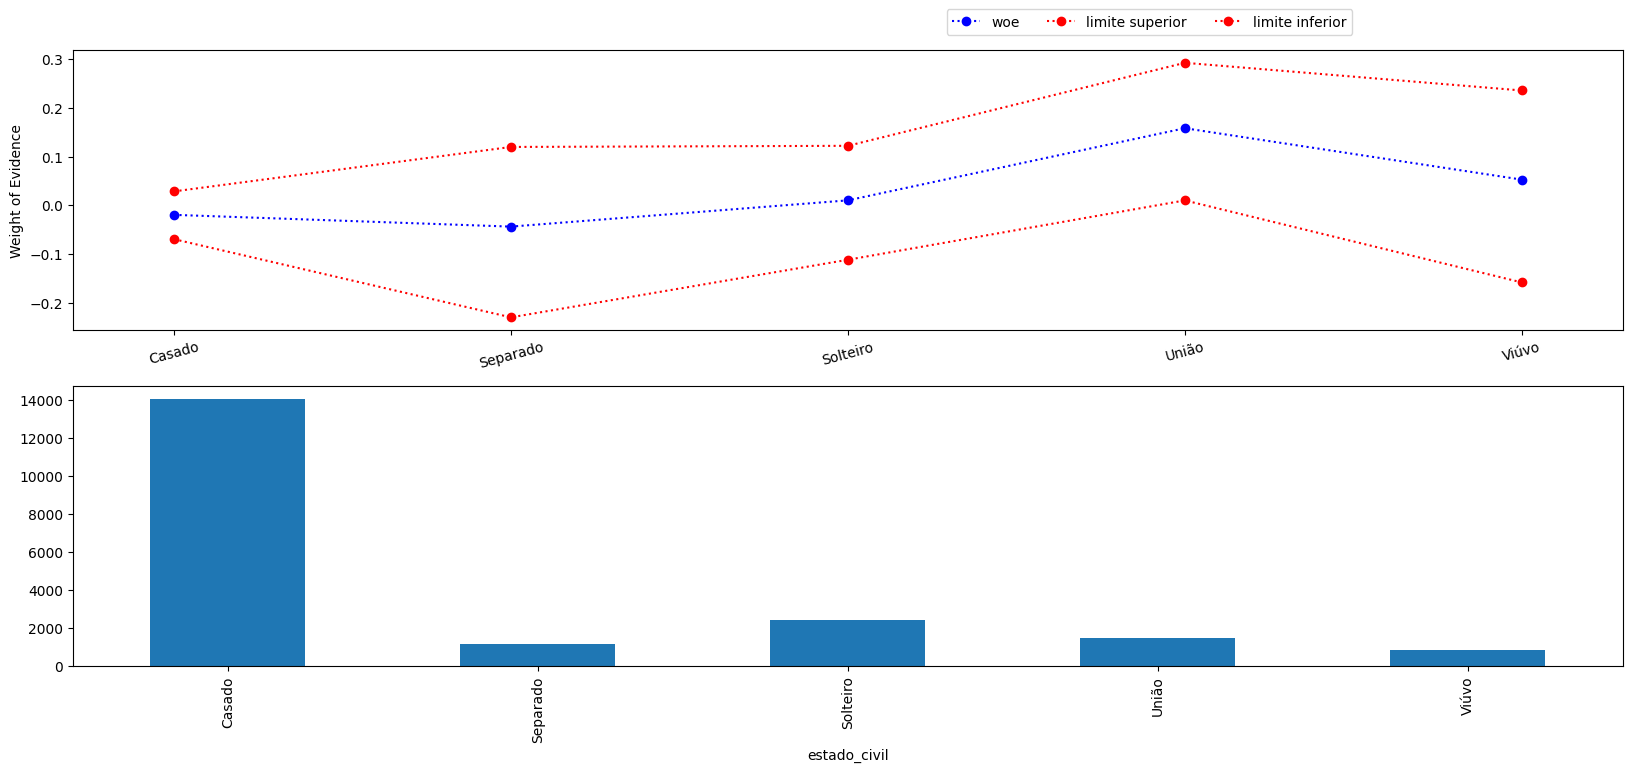

In [ ]:
c += 1
biv_discreta(var=categorias[c], df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_29028\1449846887.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau


,qt_bom,qt_mau,mau,tipo_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_residencia,,,,,,,,,,,,,,
Aluguel,244,41,0.143860,Aluguel,285,0.020788,0.184778,0.102941,-1.783596,-1.484303,-2.164967,0.091766,0.391059,-0.289605
Casa,15546,2364,0.131993,Casa,17910,0.002529,0.136951,0.127036,-1.883448,-1.840850,-1.927426,-0.008086,0.034513,-0.052064
Com os pais,780,131,0.143798,Com os pais,911,0.011625,0.166614,0.120982,-1.784097,-1.609820,-1.983159,0.091266,0.265542,-0.107797
Comunitário,74,14,0.159091,Comunitário,88,0.038990,0.236588,0.081594,-1.665008,-1.171476,-2.420889,0.210354,0.703886,-0.545527
Estúdio,135,15,0.100000,Estúdio,150,0.024495,0.148402,0.051598,-2.197225,-1.747188,-2.911300,-0.321862,0.128174,-1.035938
Governamental,527,88,0.143089,Governamental,615,0.014120,0.170819,0.115360,-1.789864,-1.579836,-2.037122,0.085498,0.295526,-0.161760


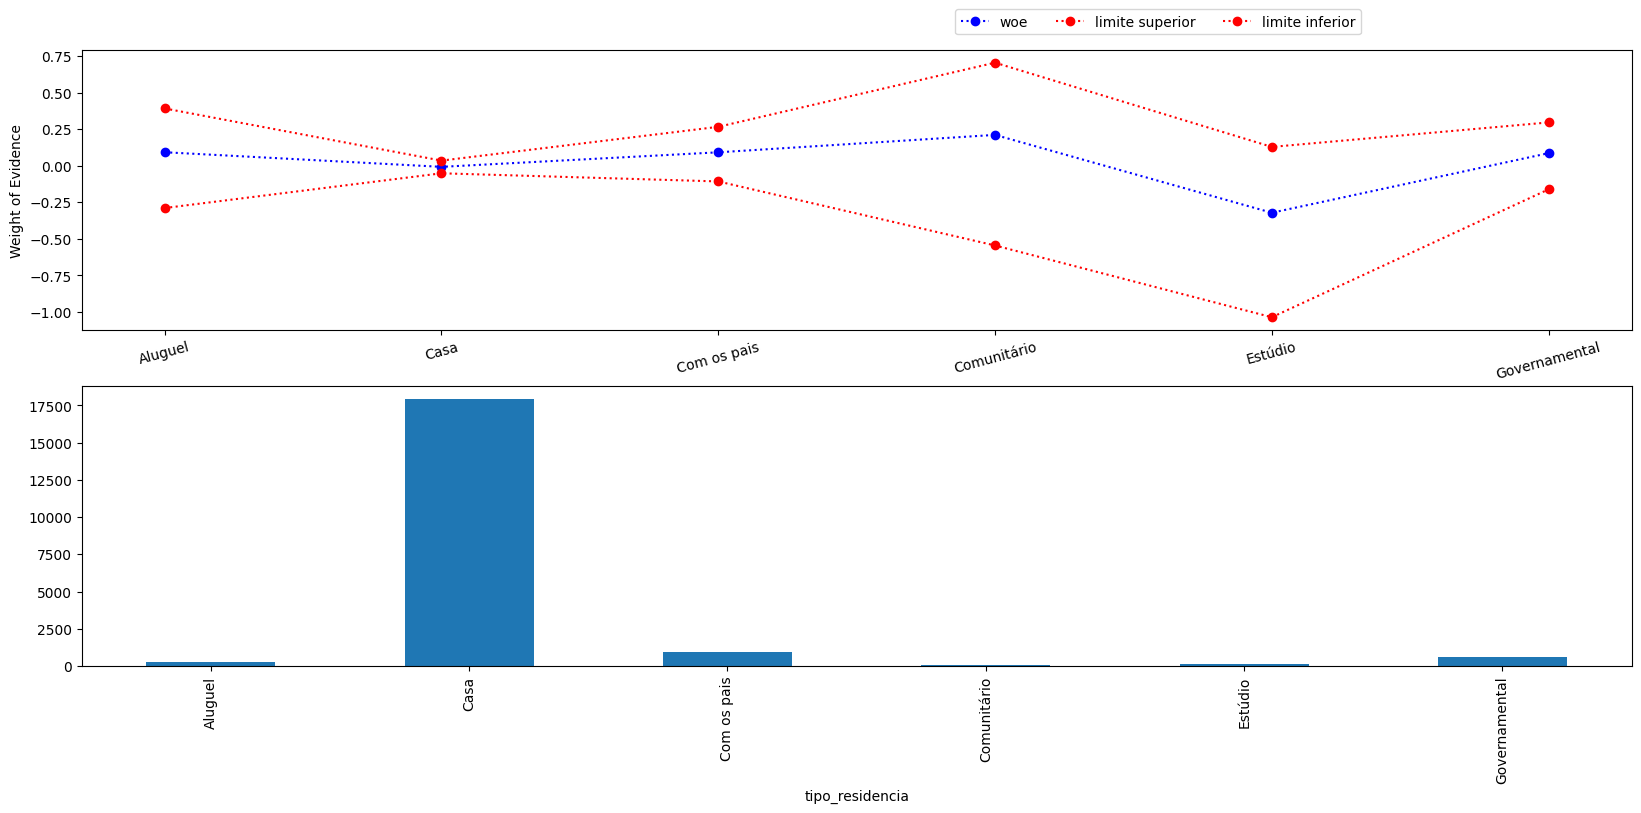

In [ ]:
c += 1
biv_discreta(var=categorias[c], df=df_valid)

In [ ]:
# Função de gráfico e calculos WOE
def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, _ = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(),
                        var: g[var].mean(),
                        'cont':g[var].count()})

    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep

    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    _, ax = plt.subplots(2,1, figsize=(20, 8))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')

    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)

    ax[1] = biv.cont.plot.bar()
    return None

In [ ]:
continuas = df_train.select_dtypes(['int64','float64']).dtypes.index
continuas

Index(['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'renda_log', 'bom'],
      dtype='object')

#### Base Teste

C:\Users\gfsil\AppData\Local\Temp\ipykernel_29028\1220190481.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_29028\1220190481.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


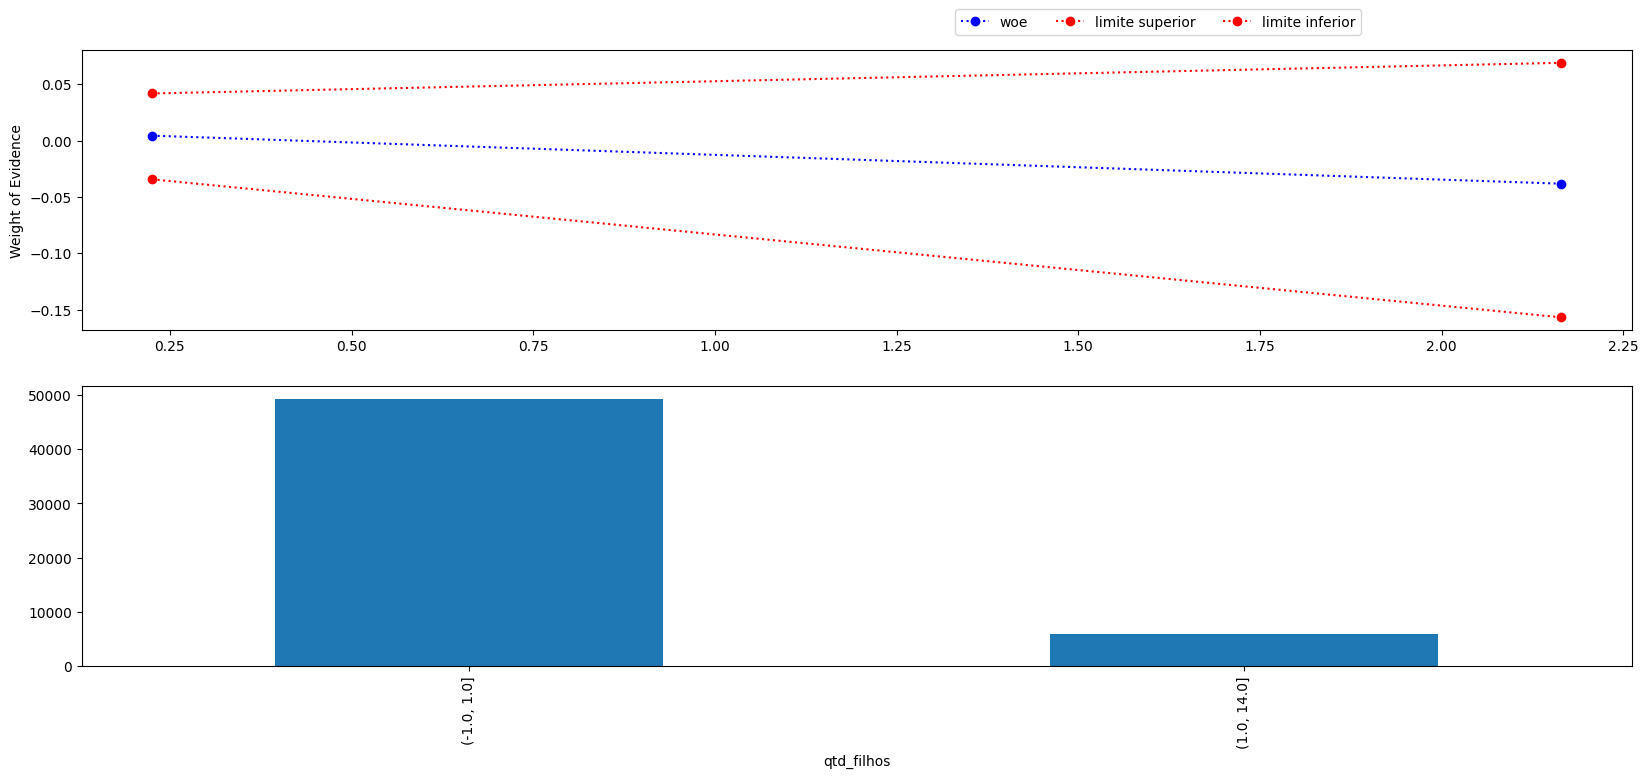

In [ ]:
c = 0
biv_continua(var=continuas[c], ncat=5, df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_29028\1220190481.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_29028\1220190481.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


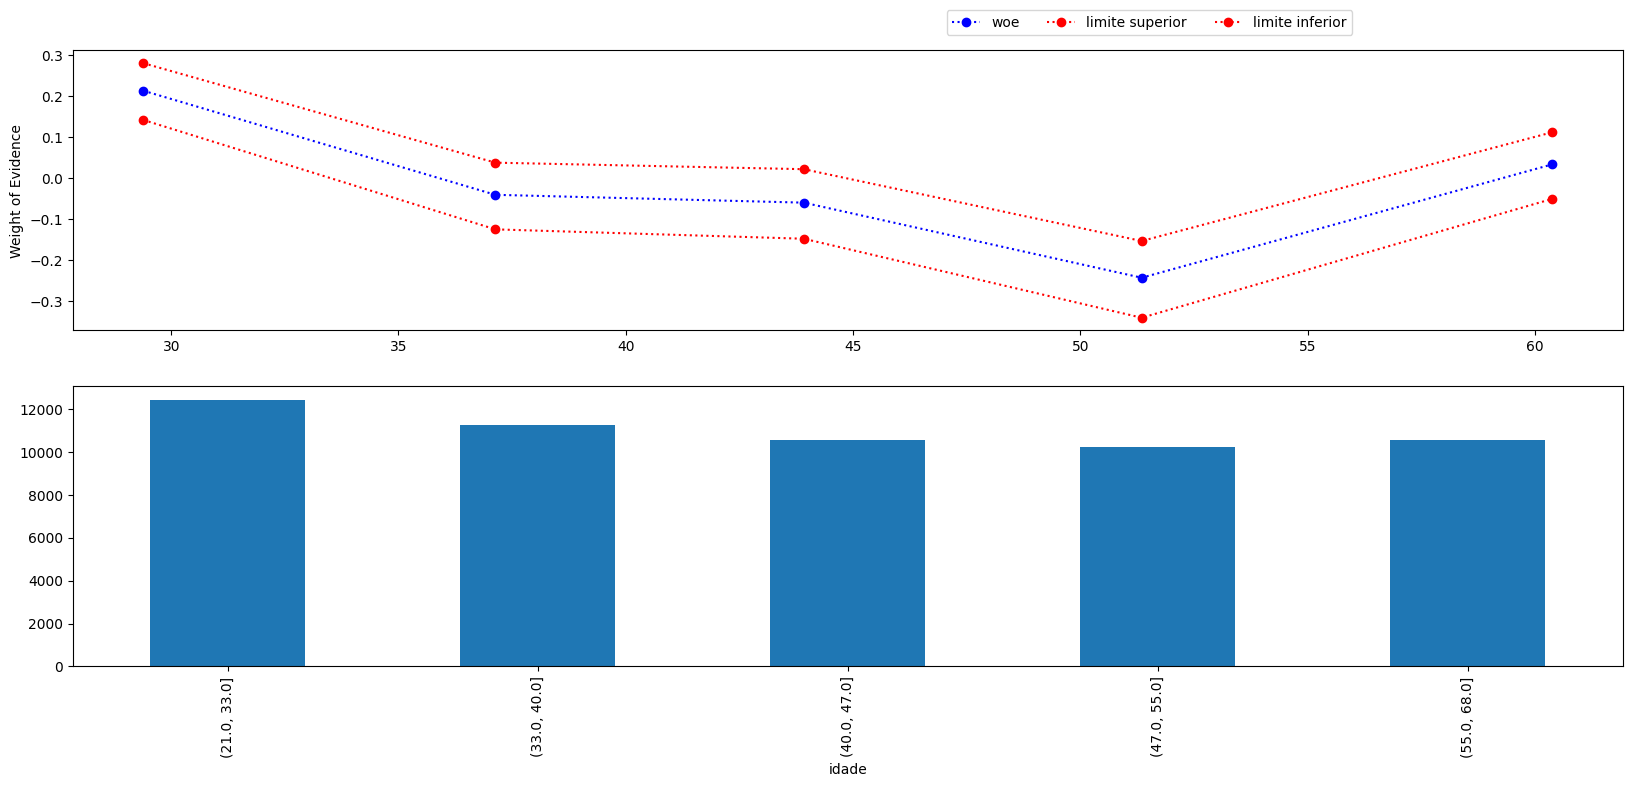

In [ ]:
c += 1
biv_continua(var=continuas[c], ncat=5, df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_29028\1220190481.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_29028\1220190481.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


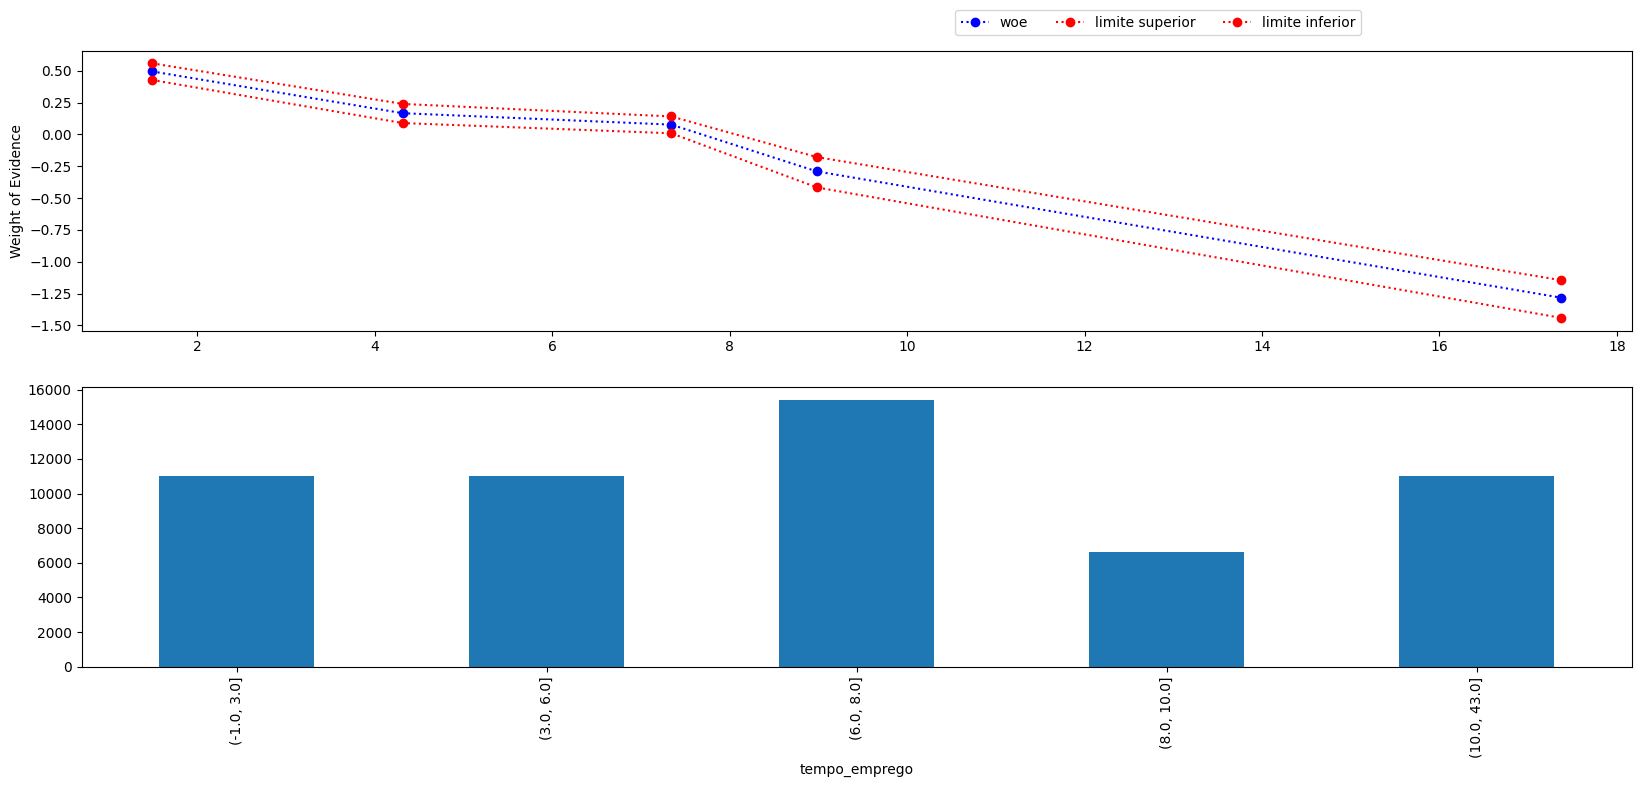

In [ ]:
c += 1
biv_continua(var=continuas[c], ncat=5, df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_29028\1220190481.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_29028\1220190481.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


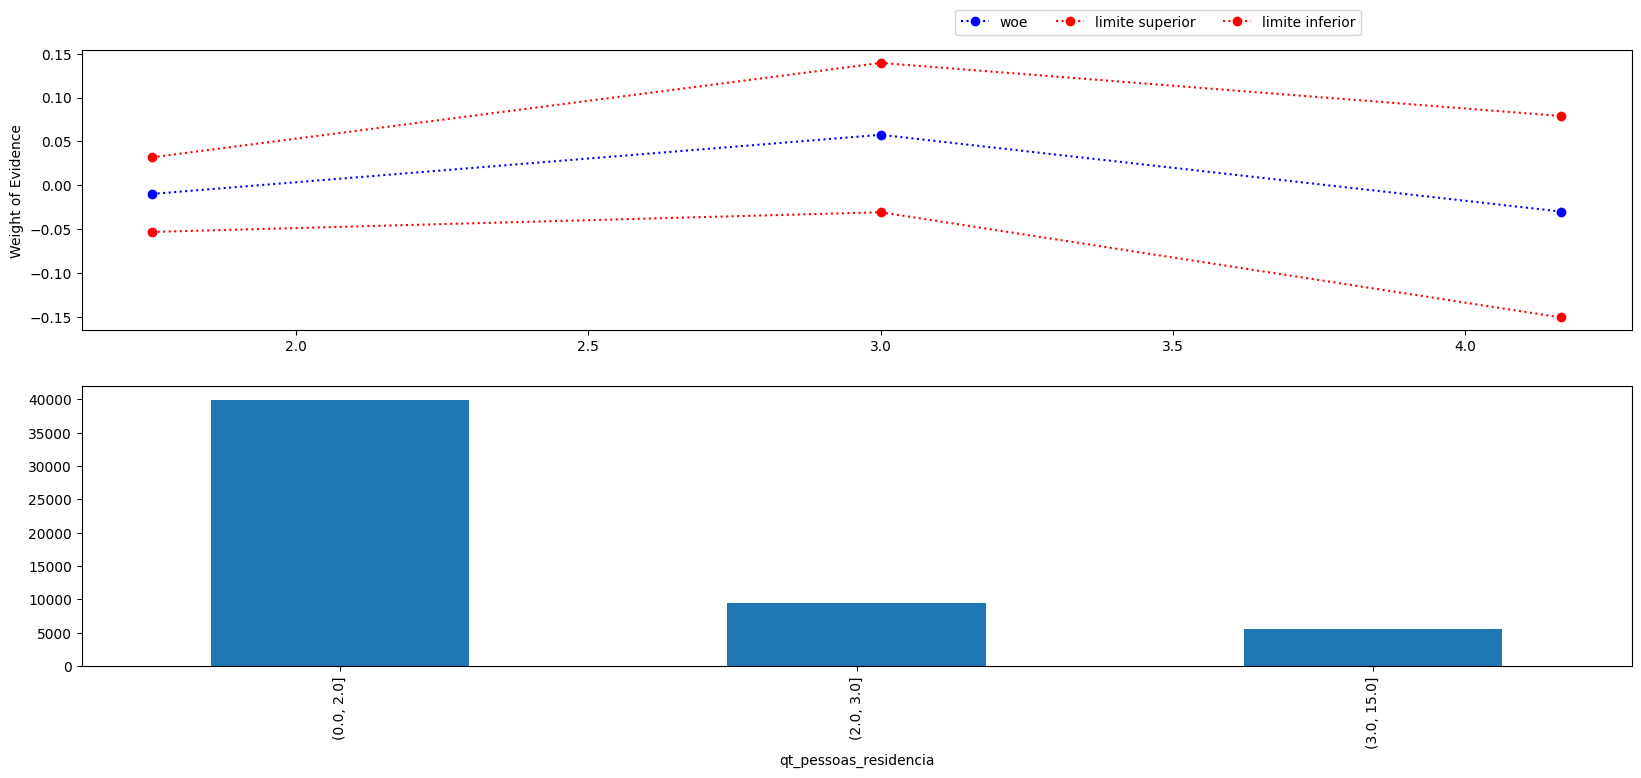

In [ ]:
c += 1
biv_continua(var=continuas[c], ncat=5, df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_29028\1220190481.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_29028\1220190481.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


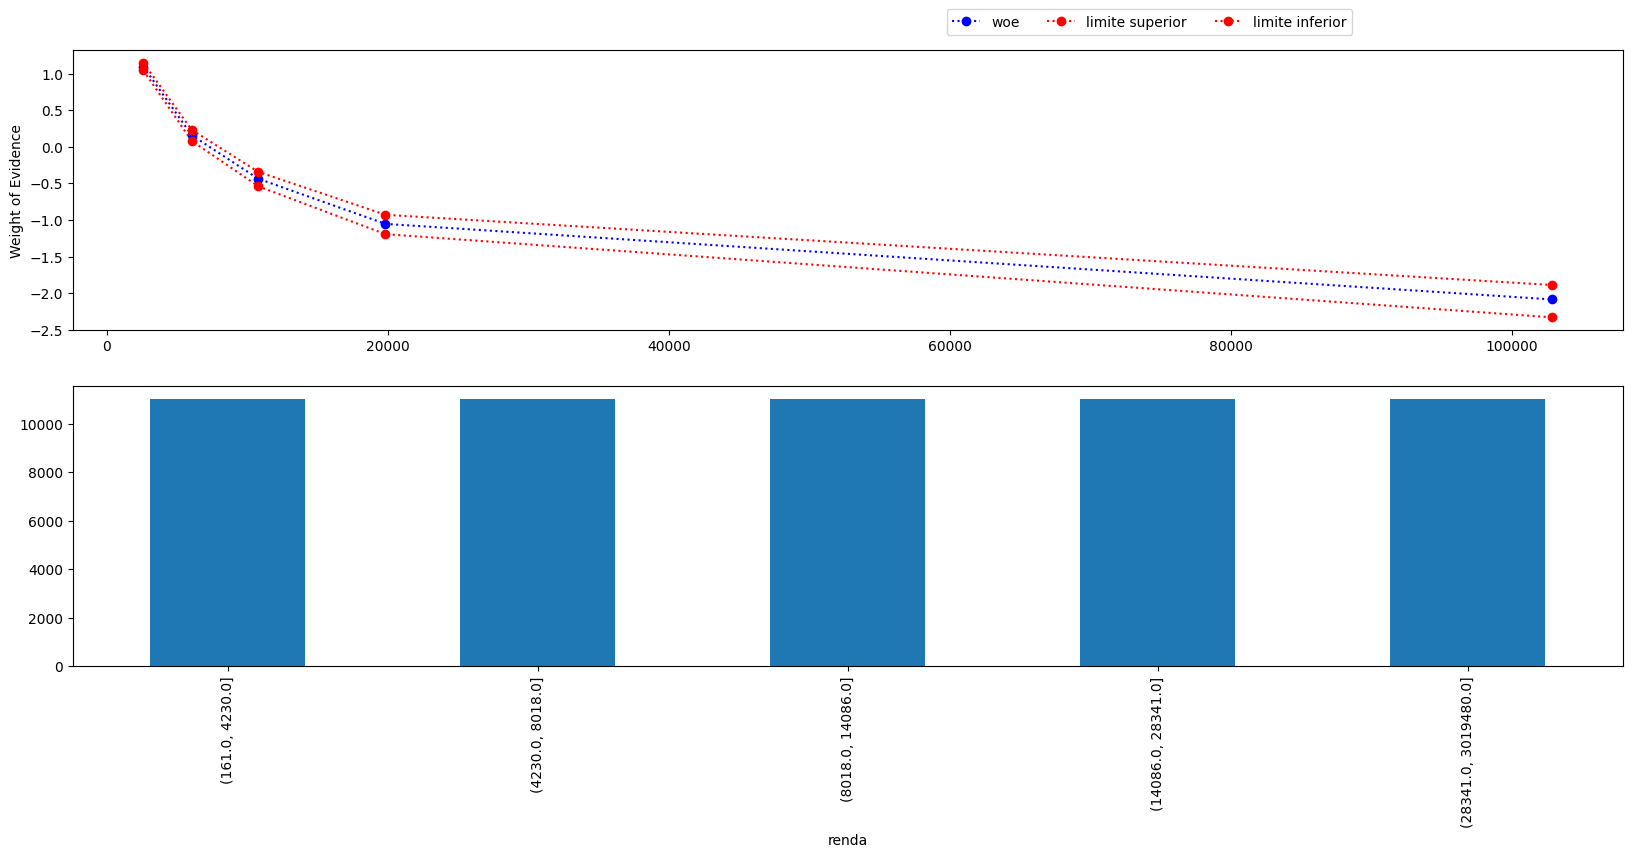

In [ ]:
c += 1
biv_continua(var=continuas[c], ncat=5, df=df_train)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_29028\1220190481.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_29028\1220190481.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


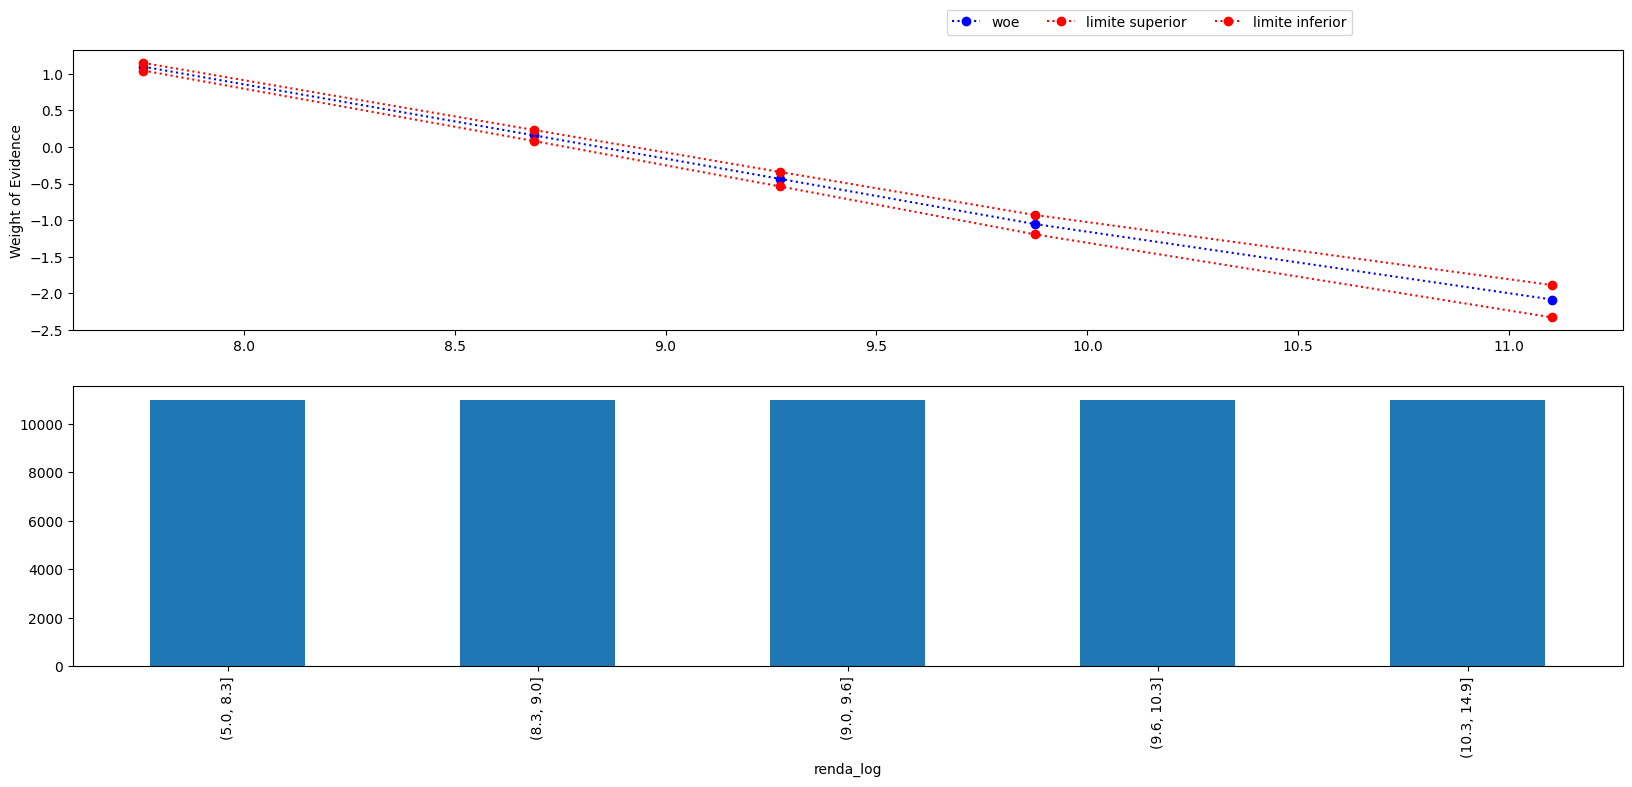

In [ ]:
c += 1
biv_continua(var=continuas[c], ncat=5, df=df_train)

#### Base Validação

C:\Users\gfsil\AppData\Local\Temp\ipykernel_29028\1220190481.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_29028\1220190481.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


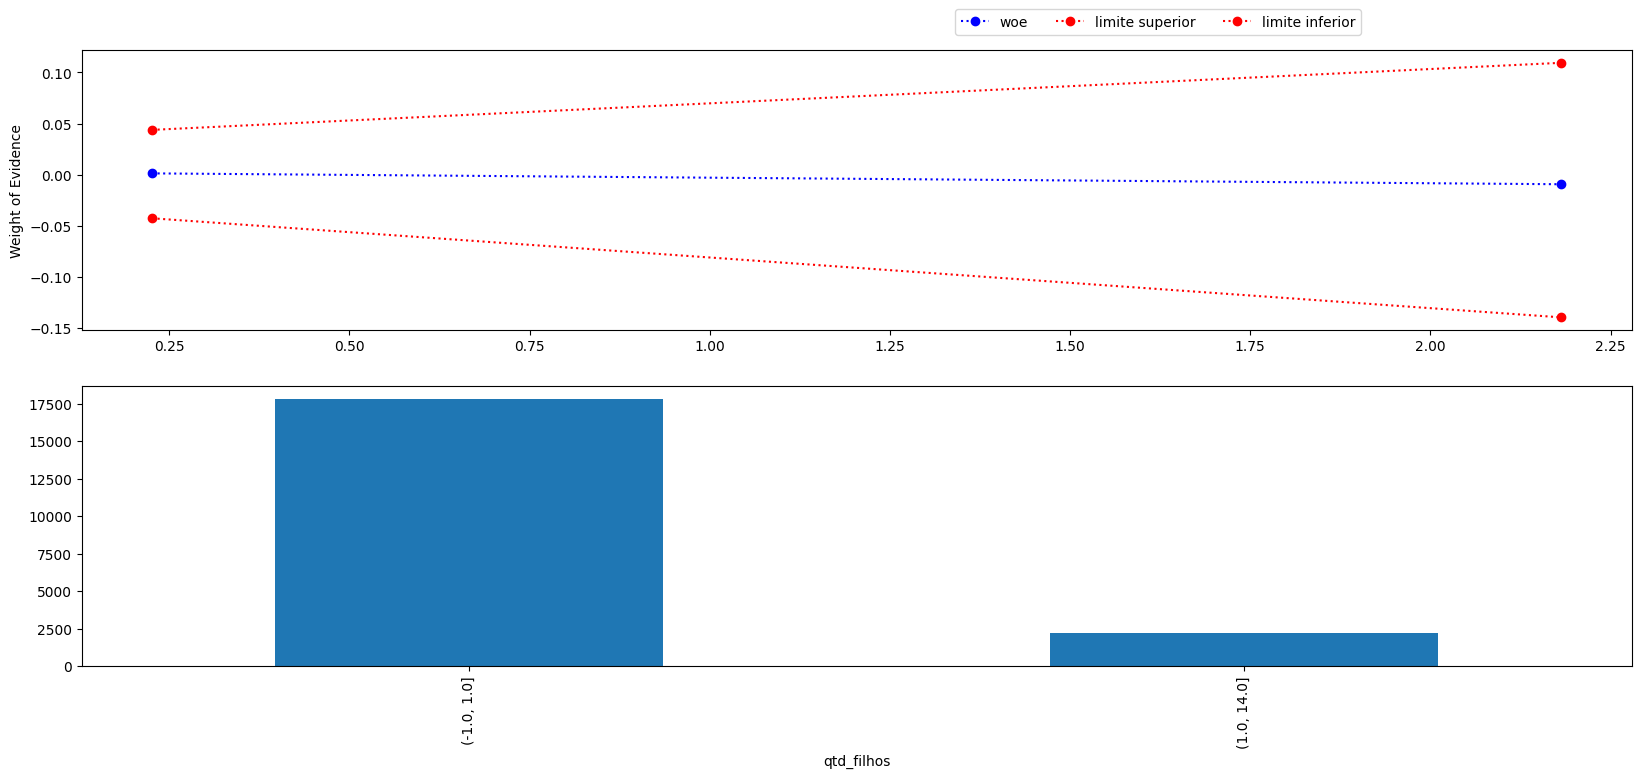

In [ ]:
c = 0
biv_continua(var=continuas[c], ncat=5, df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_29028\1220190481.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_29028\1220190481.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


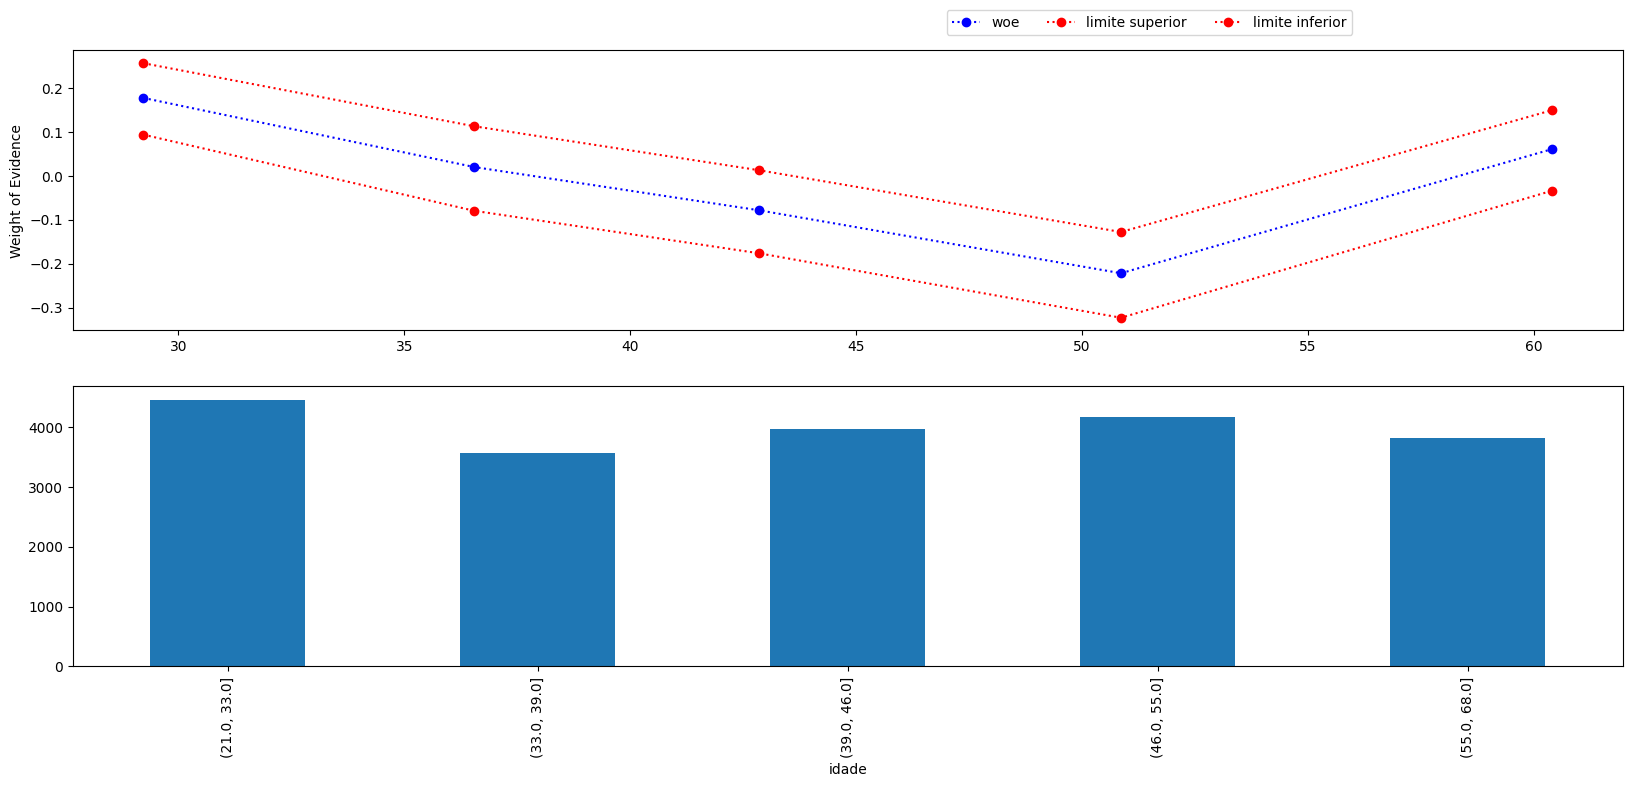

In [ ]:
c += 1
biv_continua(var=continuas[c], ncat=5, df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_29028\1220190481.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_29028\1220190481.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


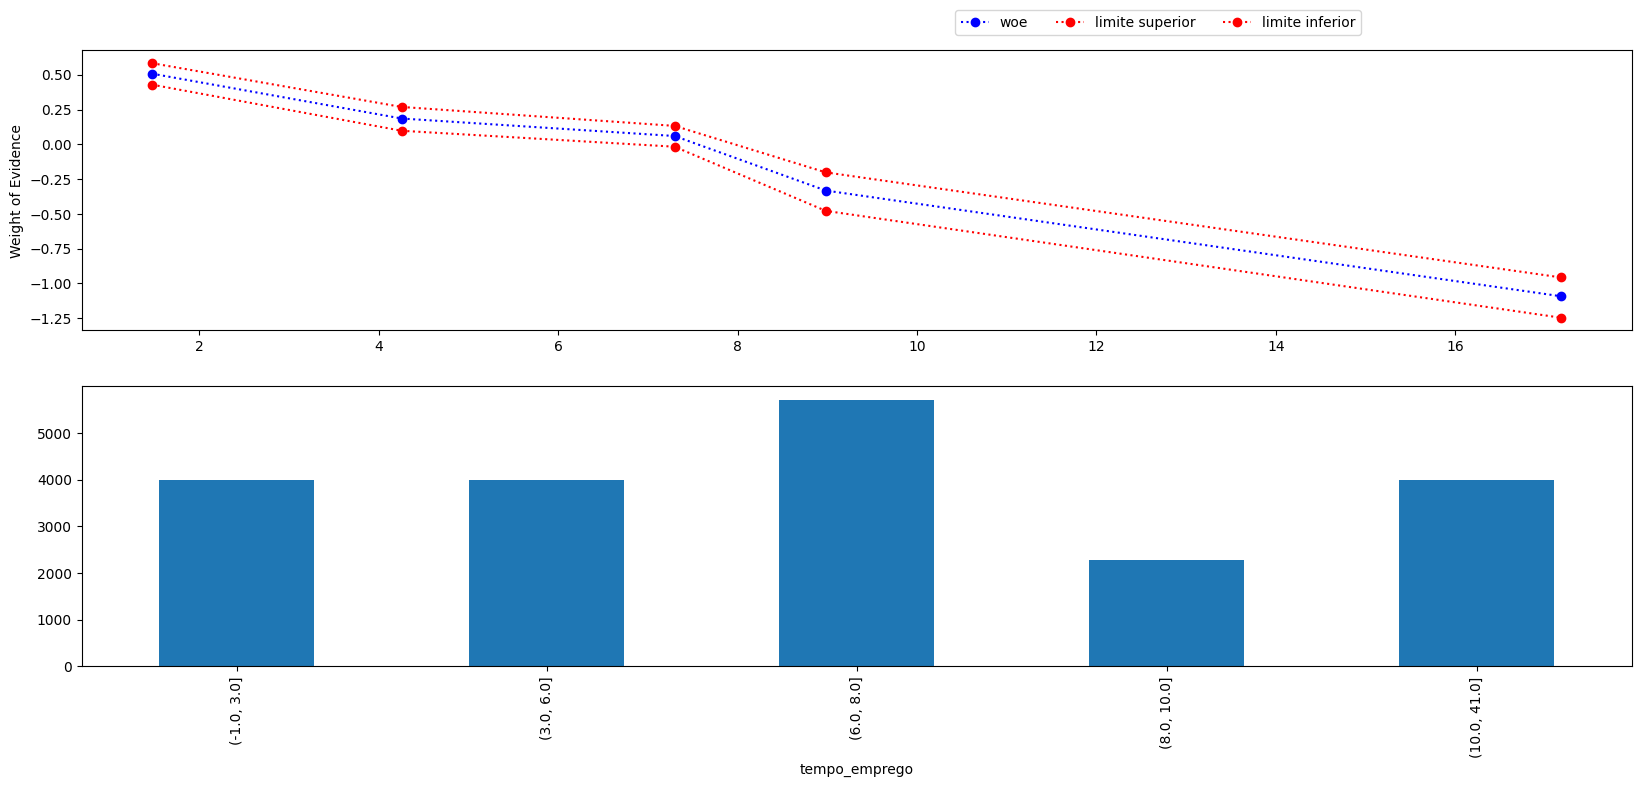

In [ ]:
c += 1
biv_continua(var=continuas[c], ncat=5, df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_29028\1220190481.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_29028\1220190481.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


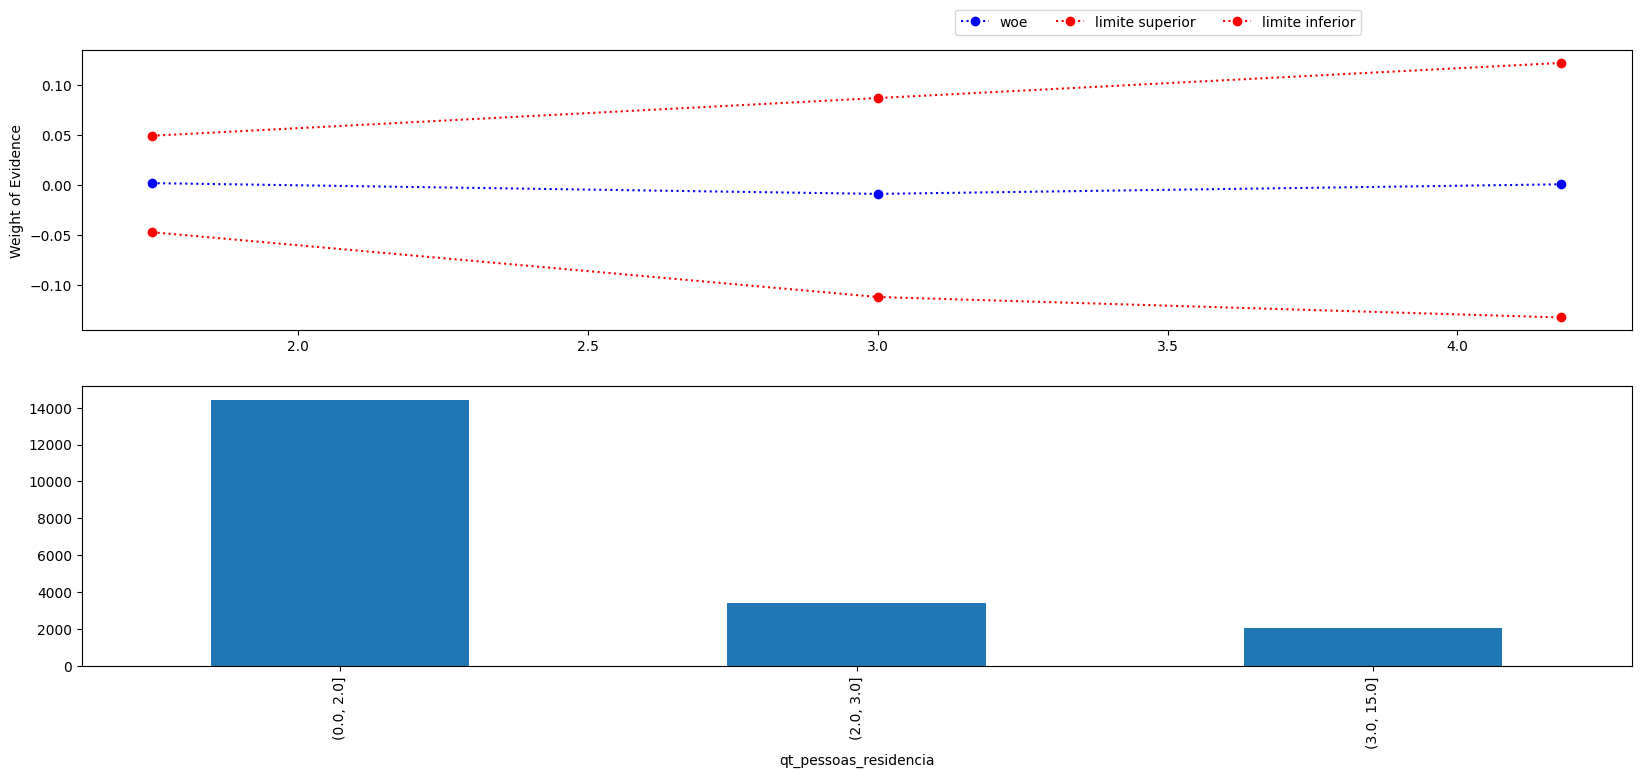

In [ ]:
c += 1
biv_continua(var=continuas[c], ncat=5, df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_29028\1220190481.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_29028\1220190481.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


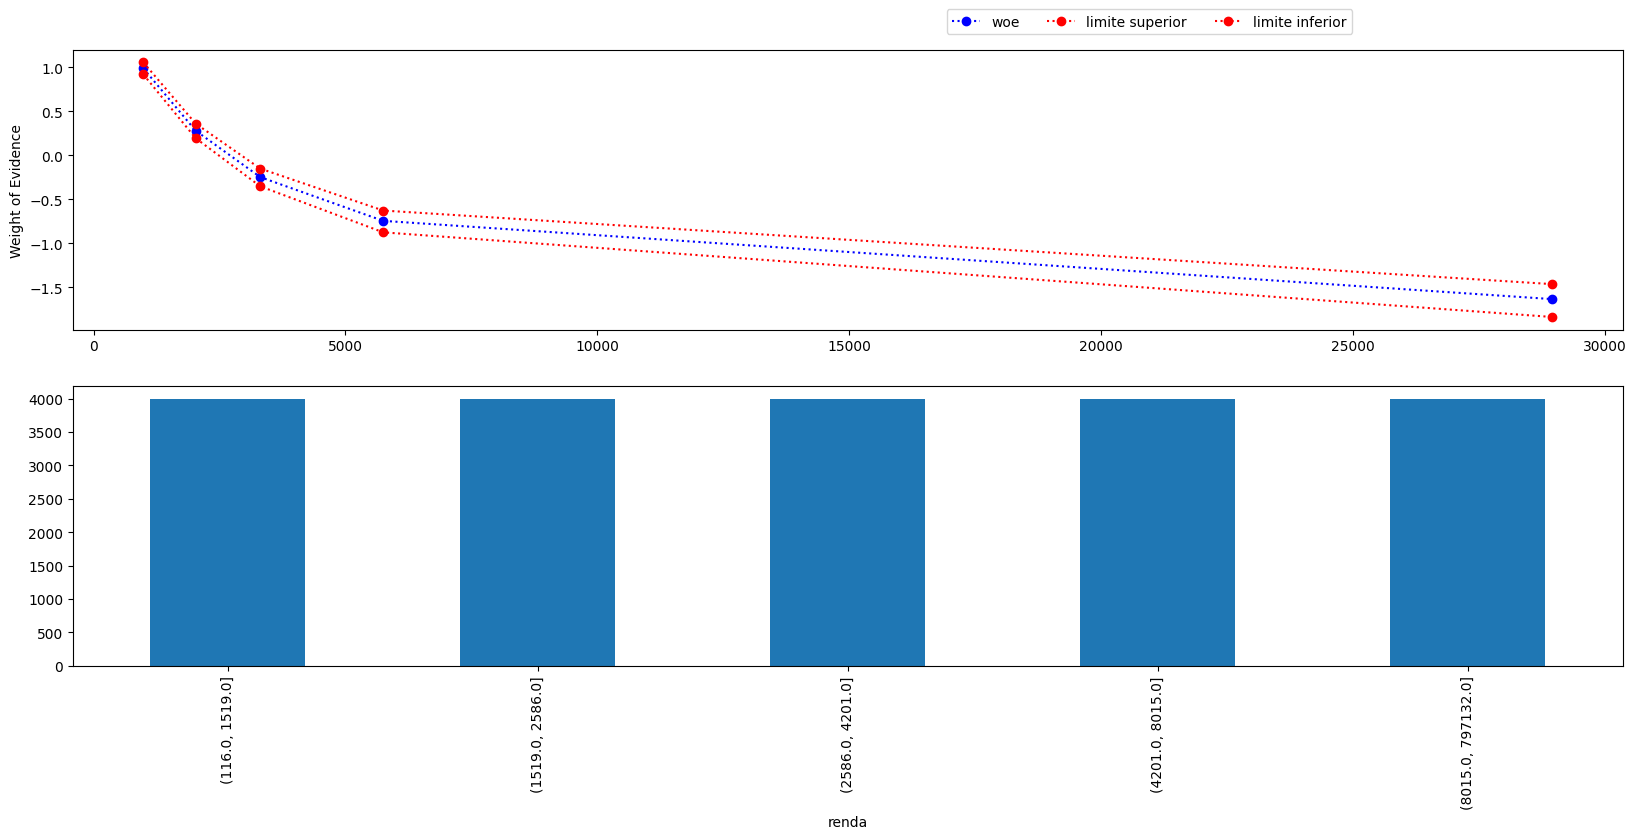

In [ ]:
c += 1
biv_continua(var=continuas[c], ncat=5, df=df_valid)

C:\Users\gfsil\AppData\Local\Temp\ipykernel_29028\1220190481.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bom'] = 1-df.mau
C:\Users\gfsil\AppData\Local\Temp\ipykernel_29028\1220190481.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(cat_srs)


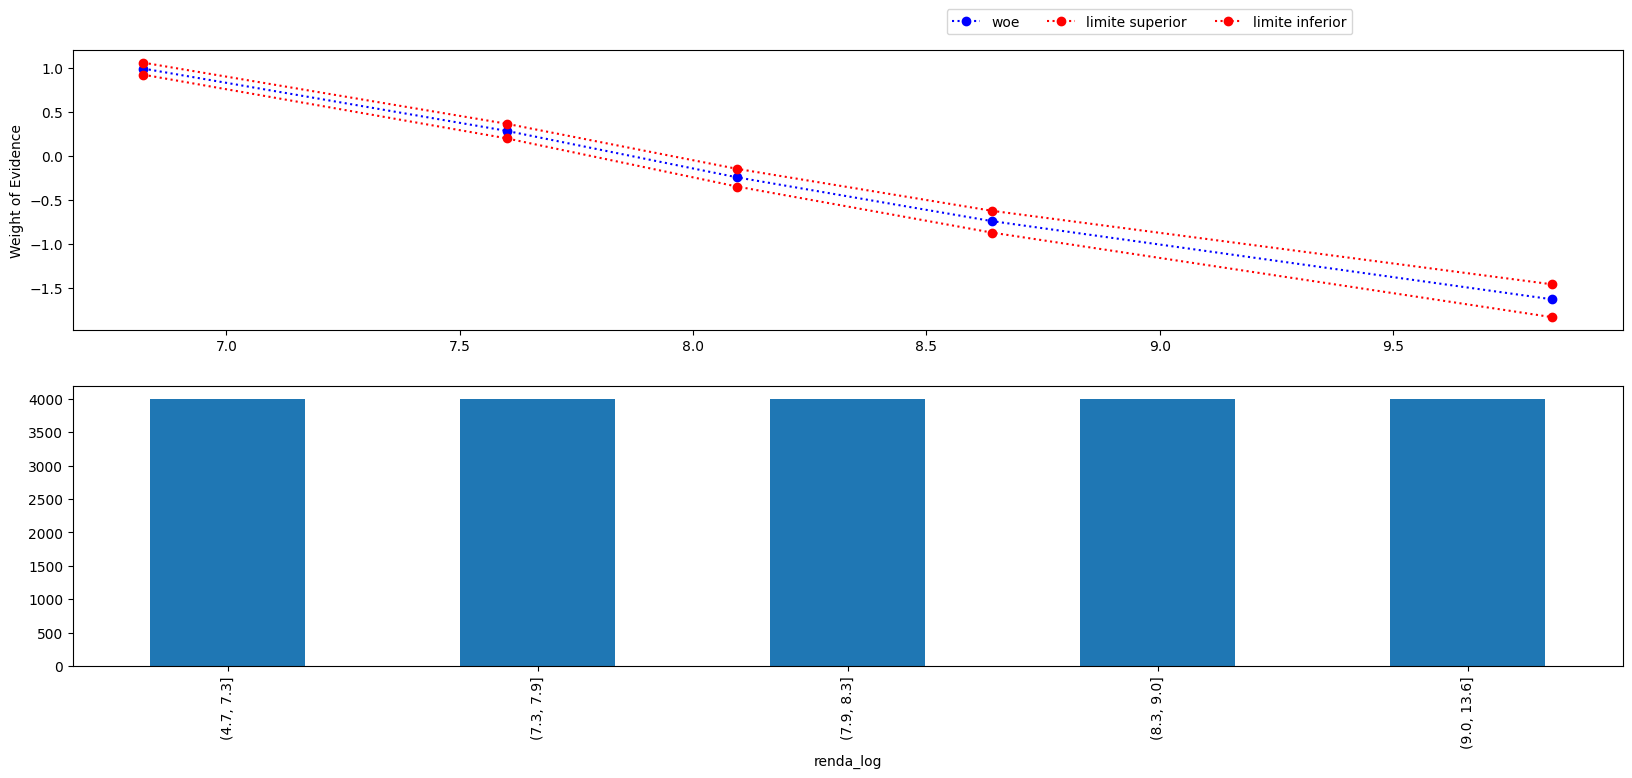

In [ ]:
c += 1
biv_continua(var=continuas[c], ncat=5, df=df_valid)

In [ ]:
metadados_train = pd.DataFrame(df_train.dtypes, columns=['dtype'])
metadados_train['nmissing'] = df_train.isna().sum()
metadados_train['valores_unicos'] = df_train.nunique()
metadados_train['papel'] = 'covariavel'
metadados_train.loc['mau','papel'] = 'resposta'
metadados_train

,dtype,nmissing,valores_unicos,papel
data_ref,datetime64[ns],0,11,covariavel
sexo,object,0,2,covariavel
posse_de_veiculo,object,0,2,covariavel
posse_de_imovel,object,0,2,covariavel
qtd_filhos,int64,0,8,covariavel
tipo_renda,object,0,5,covariavel
educacao,object,0,5,covariavel
estado_civil,object,0,5,covariavel
tipo_residencia,object,0,6,covariavel
idade,int64,0,47,covariavel


In [ ]:
metadados_valid = pd.DataFrame(df_valid.dtypes, columns=['dtype'])
metadados_valid['nmissing'] = df_valid.isna().sum()
metadados_valid['valores_unicos'] = df_valid.nunique()
metadados_valid['papel'] = 'covariavel'
metadados_valid.loc['mau','papel'] = 'resposta'
metadados_valid

,dtype,nmissing,valores_unicos,papel
data_ref,datetime64[ns],0,4,covariavel
sexo,object,0,2,covariavel
posse_de_veiculo,object,0,2,covariavel
posse_de_imovel,object,0,2,covariavel
qtd_filhos,int64,0,8,covariavel
tipo_renda,object,0,5,covariavel
educacao,object,0,5,covariavel
estado_civil,object,0,5,covariavel
tipo_residencia,object,0,6,covariavel
idade,int64,0,47,covariavel


## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [ ]:
# Define a suavização dos dados na variável lowess
lowess_train = sm.nonparametric.lowess(df_train['renda_log'], df_train['tempo_emprego'], frac=1/9)
lowess_valid = sm.nonparametric.lowess(df_valid['renda_log'], df_valid['tempo_emprego'], frac=1/9)

# Valores de X e Y suavizados
f_train = interp1d(lowess_train[:, 0], lowess_train[:, 1], bounds_error=False)
f_valid = interp1d(lowess_valid[:, 0], lowess_valid[:, 1], bounds_error=False)

df_train.loc[:, 'tempo_emprego_lowess'] = f_train(df_train['tempo_emprego'])
df_valid.loc[:, 'tempo_emprego_lowess'] = f_valid(df_valid['tempo_emprego'])
df_train.head()

d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
C:\Users\gfsil\AppData\Local\Temp\ipykernel_29028\866355704.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, 'tempo_emprego_lowess'] = f_train(df_train['tempo_emprego'])
C:\Users\gfsil\AppData\Local\Temp\ipykernel_29028\866355704.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,renda_log,month,bom,tempo_emprego_lowess
486701,2015-10-01,F,N,S,0,Assalariado,Médio,Viúvo,Casa,47,0.389041,1.0,7627.46,False,8.939510,10,1,8.432785
319477,2015-07-01,F,N,N,1,Assalariado,Médio,Viúvo,Casa,50,12.608219,2.0,77195.96,False,11.254102,7,1,10.037546
172314,2015-04-01,F,S,S,0,Pensionista,Médio,Casado,Casa,54,7.746687,2.0,10550.26,False,9.263906,4,1,10.145665
57326,2015-02-01,F,N,S,0,Assalariado,Superior completo,Solteiro,Casa,39,8.660274,1.0,2995.26,False,8.004786,2,1,9.455074
494801,2015-10-01,F,N,S,0,Assalariado,Médio,Casado,Casa,54,29.534247,2.0,361611.23,False,12.798325,10,1,12.079553


In [ ]:
df_valid.head()

,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,renda_log,month,bom,tempo_emprego_lowess
643626,2016-01-01,M,N,S,0,Pensionista,Fundamental,Casado,Casa,65,7.746687,2.0,3608.11,False,8.190939,1,1,8.190939
679205,2016-02-01,F,S,N,0,Assalariado,Superior completo,Casado,Governamental,49,5.493151,2.0,1237.05,True,7.120485,2,0,7.946309
674647,2016-02-01,F,N,S,0,Empresário,Médio,Casado,Casa,41,19.452055,2.0,5646.19,False,8.638736,2,1,9.864746
640419,2016-01-01,F,N,N,0,Assalariado,Médio,Viúvo,Casa,45,5.515068,1.0,2767.13,False,7.925566,1,1,7.949795
746772,2016-03-01,F,N,S,0,Pensionista,Médio,Viúvo,Casa,58,7.746687,1.0,3037.63,False,8.018833,3,1,8.190939


In [ ]:
# Obtendo a primeira regreção com todas as variáveis
formula = '''
            renda_log ~
            C(tipo_renda, Treatment('Pensionista')) +
            tempo_emprego_lowess
'''
reg_redc = smf.ols(formula=formula, data=df_train).fit()

reg_redc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     8451.
Date:                Thu, 09 Jan 2025   Prob (F-statistic):               0.00
Time:                        16:39:20   Log-Likelihood:                -72673.
No. Observations:               55041   AIC:                         1.454e+05
Df Residuals:                   55035   BIC:                         1.454e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
Intercept                                                      -1.0927      0.052    -21.095      0.000      -1.194      -0.991
C(tipo_renda, Treatment('Pensionista'))[T.Assalariado]          0.9904      0.012     86.038      0.000       0.968       1.013
C(tipo_renda, Treatment('Pensionista'))[T.Bolsista]             0.8209      0.166      4.954      0.000       0.496       1.146
C(tipo_renda, Treatment('Pensionista'))[T.Empresário]           1.1476      0.013     86.740      0.000       1.122       1.174
C(tipo_renda, Treatment('Pensionista'))[T.Servidor público]     1.1059      0.016     68.021      0.000       1.074       1.138
tempo_emprego_lowess                                            1.0042      0.005    200.040      0.000       0.994       1.014
==============================================================================
Omnibus:                      104.084   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.112
Skew:                          -0.093   Prob(JB):                     6.71e-23
Kurtosis:                       2.901   Cond. No.                         413.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# Sumário dos dados de treinamento do modelo
reg_redc_summary_frame = reg_redc.get_influence().summary_frame()
reg_redc_summary_frame.head()

,dfb_Intercept,"dfb_C(tipo_renda, Treatment('Pensionista'))[T.Assalariado]","dfb_C(tipo_renda, Treatment('Pensionista'))[T.Bolsista]","dfb_C(tipo_renda, Treatment('Pensionista'))[T.Empresário]","dfb_C(tipo_renda, Treatment('Pensionista'))[T.Servidor público]",dfb_tempo_emprego_lowess,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
486701,0.003315,0.000649,-0.000039,-0.001152,-0.000354,-0.003372,4.239546e-06,0.632610,0.000064,0.005044,0.632607,0.005044
319477,-0.004932,0.005537,0.000057,0.001715,0.000527,0.005016,1.581689e-05,1.408454,0.000048,0.009742,1.408467,0.009742
172314,0.000352,-0.001589,-0.000110,-0.001383,-0.001125,0.000001,6.236013e-07,0.185282,0.000109,0.001934,0.185280,0.001934
57326,0.000503,-0.004407,-0.000006,-0.000175,-0.000054,-0.000512,1.379430e-05,-1.531906,0.000035,-0.009098,-1.531925,-0.009098
494801,-0.012427,0.006483,0.000145,0.004320,0.001329,0.012639,3.085540e-05,0.849635,0.000256,0.013606,0.849633,0.013606


In [ ]:
# Análise dos valores com maior peso no modelo
remov_index_max = reg_redc_summary_frame['hat_diag'].max()
remov_index = reg_redc_summary_frame[reg_redc_summary_frame['hat_diag'] == remov_index_max]['hat_diag'].index
remov_index

Index([393214, 525822,  90501, 158522, 154014,  56432, 479997,  83455,  60089,
       164044, 397727, 407810, 239677, 367326, 458928, 519928, 499911,  65656,
       492018, 261767, 400834, 135945, 380527, 314690, 147882, 440234, 206856,
       492948,  16678, 451865],
      dtype='int64')

In [ ]:
# Remoção dos valores ouliers com maior peso do modelo
df_train_outliers = df_train.drop(remov_index)
df_train_outliers.head()

,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,renda_log,month,bom,tempo_emprego_lowess
486701,2015-10-01,F,N,S,0,Assalariado,Médio,Viúvo,Casa,47,0.389041,1.0,7627.46,False,8.939510,10,1,8.432785
319477,2015-07-01,F,N,N,1,Assalariado,Médio,Viúvo,Casa,50,12.608219,2.0,77195.96,False,11.254102,7,1,10.037546
172314,2015-04-01,F,S,S,0,Pensionista,Médio,Casado,Casa,54,7.746687,2.0,10550.26,False,9.263906,4,1,10.145665
57326,2015-02-01,F,N,S,0,Assalariado,Superior completo,Solteiro,Casa,39,8.660274,1.0,2995.26,False,8.004786,2,1,9.455074
494801,2015-10-01,F,N,S,0,Assalariado,Médio,Casado,Casa,54,29.534247,2.0,361611.23,False,12.798325,10,1,12.079553


In [ ]:
# Obtendo a primeira regreção com todas as variáveis
formula = '''
            renda_log ~
            C(tipo_renda, Treatment('Pensionista')) +
            tempo_emprego_lowess
'''
reg_redc = smf.ols(formula=formula, data=df_train_outliers).fit()

reg_redc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                 1.056e+04
Date:                Thu, 09 Jan 2025   Prob (F-statistic):               0.00
Time:                        17:18:08   Log-Likelihood:                -72637.
No. Observations:               55011   AIC:                         1.453e+05
Df Residuals:                   55006   BIC:                         1.453e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
Intercept                                                      -1.0927      0.052    -21.094      0.000      -1.194      -0.991
C(tipo_renda, Treatment('Pensionista'))[T.Assalariado]          0.9904      0.012     86.033      0.000       0.968       1.013
C(tipo_renda, Treatment('Pensionista'))[T.Empresário]           1.1476      0.013     86.735      0.000       1.122       1.174
C(tipo_renda, Treatment('Pensionista'))[T.Servidor público]     1.1059      0.016     68.017      0.000       1.074       1.138
tempo_emprego_lowess                                            1.0042      0.005    200.028      0.000       0.994       1.014
==============================================================================
Omnibus:                      104.573   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.572
Skew:                          -0.093   Prob(JB):                     5.33e-23
Kurtosis:                       2.900   Cond. No.                         132.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# Salvando em disco o modelo e os registros de treinamento
dump(reg_redc_summary_frame, "./data/reg_redc_summary_frame")
dump(reg_redc, "./data/reg_redc")

['./data/reg_redc']

## Conclussão

- Trate valores missings e outliers
<br>R.: Valores missing foram substituídos pela média.

- Trate 'zeros estruturais'
<br>R.: Não foram encontrados zeros estruturais.

- Faça agrupamentos de categorias conforme vimos em aula
<br>R.: Não foi necessário agrupar categorias.

- Proponha uma equação preditiva para 'mau'
<br>R,: Equação mais eficiente usa tempo de emprego suavizado e tipo de renda com cazela de Pnesionista

- Caso hajam categorias não significantes, justifique
<br>R.: Categorias não significativas foram resolvidas com a retirada dos outliers.

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

Treino

In [ ]:
# Obtenção da predição na base de treino
df_train_outliers['y_pred'] = reg_redc.predict(df_train_outliers)
y_pred = df_train_outliers['y_pred']
y_true = df_train_outliers['renda_log']

In [ ]:
# KS
ks_2samp(y_true, y_pred)

KstestResult(statistic=np.float64(0.2005235316573049), pvalue=np.float64(0.0), statistic_location=np.float64(8.352709981040144), statistic_sign=np.int8(1))

In [ ]:
# Gini
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

gini(y_pred)

np.float64(0.04250038998778438)

Validação

In [ ]:
# Removendo uma das categorias da base de validação, que não está presente no teste
df_valid = df_valid[~(df_valid['tipo_renda'] == "Bolsista")]
df_valid['tipo_renda'].value_counts()

tipo_renda
Assalariado         10324
Empresário           4663
Pensionista          3300
Servidor público     1659
Name: count, dtype: int64

In [ ]:
# Obtenção da predição na base de treino
df_valid['y_pred'] = reg_redc.predict(df_valid)
y_pred = df_valid['y_pred']
y_true = df_valid['renda_log']

In [ ]:
# KS
ks_2samp(y_true, y_pred)

KstestResult(statistic=np.float64(0.14709716233831344), pvalue=np.float64(8.249371831026902e-189), statistic_location=np.float64(7.132816989452251), statistic_sign=np.int8(1))

In [ ]:
# Gini
def gini(x):
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

gini(y_pred)

np.float64(0.056879492852511995)

### Conclusão
- Não foram observadas diferenças significativas entre a base de treino e a de validação
  
|Base|KS|Gini|
|-|-|-|
|Treino|0.204|0.042|
|Validação|0.17|0.049|

- Não é possível obter a acurácia de um modelo de predição para variável contínua

# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento

## Pré processamento

In [ ]:
# Carregando base
df = pd.read_feather('./../36_modulo/data/credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [ ]:
df.isna().sum()

data_ref                      0
index                         0
sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125957
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64

In [ ]:
# Obtendo amostra da base para a modelagem, devido ao grande número de instâncias
df_copy = df.sample(frac=.1).copy()

# Inserindo dados faltantes com média em tempo de emprego
df_copy.fillna({"tempo_emprego": np.mean(df_copy['tempo_emprego'])}, inplace=True)
df_copy.isna().sum()

data_ref                 0
index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
dtype: int64

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [ ]:
# Obtendo a primeira regreção com todas as variáveis
formula = '''
            renda_log ~
            C(tipo_renda, Treatment('Pensionista')) +
            tempo_emprego_lowess
'''
reg_redc = smf.ols(formula=formula, data=df_train).fit()

reg_redc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              renda_log   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     8451.
Date:                Thu, 09 Jan 2025   Prob (F-statistic):               0.00
Time:                        17:24:12   Log-Likelihood:                -72673.
No. Observations:               55041   AIC:                         1.454e+05
Df Residuals:                   55035   BIC:                         1.454e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================================================================
                                                                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------
Intercept                                                      -1.0927      0.052    -21.095      0.000      -1.194      -0.991
C(tipo_renda, Treatment('Pensionista'))[T.Assalariado]          0.9904      0.012     86.038      0.000       0.968       1.013
C(tipo_renda, Treatment('Pensionista'))[T.Bolsista]             0.8209      0.166      4.954      0.000       0.496       1.146
C(tipo_renda, Treatment('Pensionista'))[T.Empresário]           1.1476      0.013     86.740      0.000       1.122       1.174
C(tipo_renda, Treatment('Pensionista'))[T.Servidor público]     1.1059      0.016     68.021      0.000       1.074       1.138
tempo_emprego_lowess                                            1.0042      0.005    200.040      0.000       0.994       1.014
==============================================================================
Omnibus:                      104.084   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.112
Skew:                          -0.093   Prob(JB):                     6.71e-23
Kurtosis:                       2.901   Cond. No.                         413.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# Sumário dos dados de treinamento do modelo
reg_redc_summary_frame = reg_redc.get_influence().summary_frame()
remov_index_max = reg_redc_summary_frame['hat_diag'].max()
remov_index = reg_redc_summary_frame[reg_redc_summary_frame['hat_diag'] == remov_index_max]['hat_diag'].index
df_train_outliers = df_train.drop(remov_index)
df_train_outliers.head()

,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,renda_log,month,bom,tempo_emprego_lowess
486701,2015-10-01,F,N,S,0,Assalariado,Médio,Viúvo,Casa,47,0.389041,1.0,7627.46,False,8.939510,10,1,8.432785
319477,2015-07-01,F,N,N,1,Assalariado,Médio,Viúvo,Casa,50,12.608219,2.0,77195.96,False,11.254102,7,1,10.037546
172314,2015-04-01,F,S,S,0,Pensionista,Médio,Casado,Casa,54,7.746687,2.0,10550.26,False,9.263906,4,1,10.145665
57326,2015-02-01,F,N,S,0,Assalariado,Superior completo,Solteiro,Casa,39,8.660274,1.0,2995.26,False,8.004786,2,1,9.455074
494801,2015-10-01,F,N,S,0,Assalariado,Médio,Casado,Casa,54,29.534247,2.0,361611.23,False,12.798325,10,1,12.079553


### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance?

In [ ]:
# Define a suavização dos dados na variável lowess
lowess_train = sm.nonparametric.lowess(df_train_outliers['renda_log'], df_train_outliers['tempo_emprego'], frac=1/9)
lowess_valid = sm.nonparametric.lowess(df_valid['renda_log'], df_valid['tempo_emprego'], frac=1/9)

# Valores de X e Y suavizados
f_train = interp1d(lowess_train[:, 0], lowess_train[:, 1], bounds_error=False)
f_valid = interp1d(lowess_valid[:, 0], lowess_valid[:, 1], bounds_error=False)

df_train_outliers.loc[:, 'tempo_emprego_lowess'] = f_train(df_train_outliers['tempo_emprego'])
df_valid.loc[:, 'tempo_emprego_lowess'] = f_valid(df_valid['tempo_emprego'])
df_train_outliers.head()

d:\OneDrive\Program\01 - scripts-base\EBAC\ebac_env\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


,data_ref,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,renda_log,month,bom,tempo_emprego_lowess
486701,2015-10-01,F,N,S,0,Assalariado,Médio,Viúvo,Casa,47,0.389041,1.0,7627.46,False,8.939510,10,1,8.433550
319477,2015-07-01,F,N,N,1,Assalariado,Médio,Viúvo,Casa,50,12.608219,2.0,77195.96,False,11.254102,7,1,10.037880
172314,2015-04-01,F,S,S,0,Pensionista,Médio,Casado,Casa,54,7.746687,2.0,10550.26,False,9.263906,4,1,8.778850
57326,2015-02-01,F,N,S,0,Assalariado,Superior completo,Solteiro,Casa,39,8.660274,1.0,2995.26,False,8.004786,2,1,9.455197
494801,2015-10-01,F,N,S,0,Assalariado,Médio,Casado,Casa,54,29.534247,2.0,361611.23,False,12.798325,10,1,12.082628


### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1.
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [ ]:
selecionar = [
    "sexo",
    "posse_de_veiculo",
    "posse_de_imovel",
    "tipo_renda",
    "educacao",
    "estado_civil",
    "tipo_residencia",
]
selecionar

['sexo',
 'posse_de_veiculo',
 'posse_de_imovel',
 'tipo_renda',
 'educacao',
 'estado_civil',
 'tipo_residencia']

In [ ]:
df_train_outliers_dummies = pd.get_dummies(df_train_outliers[selecionar], drop_first=True)
df_train_outliers_dummies.head()

,sexo_M,posse_de_veiculo_S,posse_de_imovel_S,tipo_renda_Empresário,tipo_renda_Pensionista,tipo_renda_Servidor público,educacao_Médio,educacao_Pós graduação,educacao_Superior completo,educacao_Superior incompleto,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
486701,False,False,True,False,False,False,True,False,False,False,False,False,False,True,True,False,False,False,False
319477,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,False,False,False
172314,False,True,True,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False
57326,False,False,True,False,False,False,False,False,True,False,False,True,False,False,True,False,False,False,False
494801,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False


### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [ ]:
pca = pd.DataFrame(PCA(n_components=5).fit_transform(df_train_outliers_dummies))
pca['tempo_emprego_lowess'] = df_train_outliers['tempo_emprego_lowess'].values
pca['renda_log'] = df_train_outliers['renda_log'].values
pca.head()

,0,1,2,3,4,tempo_emprego_lowess,renda_log
0,0.624581,-0.375954,0.223658,0.000365,0.012297,8.433550,8.939510
1,0.560946,-0.209163,-0.688108,-0.166966,-0.136030,10.037880,11.254102
2,0.451378,0.111300,0.573016,-0.441745,-0.743215,8.778850,9.263906
3,-0.708910,-0.917536,0.192798,-0.052914,0.338633,9.455197,8.004786
4,0.585449,-0.320054,0.205049,0.052506,0.068135,12.082628,12.798325


### Pipeline

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [ ]:
# Teste de função própria para o Pipeline

def soma_teste_func(a: list) -> int|float:
    resultado_soma = sum(a)
    valor_maximo = max(a)
    return (resultado_soma, valor_maximo)

def divide_teste_func(b: list) -> float:
    return b[0]/b[1]

soma_teste_trans = FunctionTransformer(soma_teste_func)
divide_teste_trans = FunctionTransformer(divide_teste_func)

teste_pipe = Pipeline(
    steps=[
        ("soma_teste", soma_teste_trans),
        ("divide_teste", divide_teste_trans)
    ]
)

teste_pipe.transform((2, 3, 4))

2.25

In [ ]:
def substitui_nulos(valores_substituir: list) -> list:
    # Substituir nulos
    df_copy_sub = valores_substituir[0]
    variavel_sub = "tempo_emprego"
    df_copy_sub.fillna({variavel_sub: np.mean(df_copy_sub[variavel_sub])}, inplace=True),
    retorno = (
        df_copy_sub,
        valores_substituir[1]
    )
    return retorno

def remove_outliers(valores_remove: list) -> pd.DataFrame:
    # Remoção de outliers
    df_train_val = valores_remove[0]
    reg_redc_summary_frame = valores_remove[1]
    remov_index_max = reg_redc_summary_frame['hat_diag'].max()
    remov_index = reg_redc_summary_frame[reg_redc_summary_frame['hat_diag'] == remov_index_max]['hat_diag'].index
    df_train_outliers = df_train_val.drop(remov_index)
    return df_train_outliers

def cria_dummies(df_train_outliers: pd.DataFrame) -> list:
    # Criação de Dummie
    selecionar = [
        "sexo",
        "posse_de_veiculo",
        "posse_de_imovel",
        "tipo_renda",
        "educacao",
        "estado_civil",
        "tipo_residencia",
    ]
    df_train_outliers_dummies = pd.get_dummies(df_train_outliers[selecionar], drop_first=True)
    return (df_train_outliers_dummies, df_train_outliers)

def cria_pca(valores_pca: list):
    # PCA
    df_train_outliers_dummies = valores_pca[0]
    df_train_outliers = valores_pca[1]
    pca = pd.DataFrame(PCA(n_components=5).fit_transform(df_train_outliers_dummies))
    pca['tempo_emprego_lowess'] = df_train_outliers['tempo_emprego_lowess'].values
    pca['renda_log'] = df_train_outliers['renda_log'].values
    return pca


enviar_transform = (
    df_train,
    reg_redc_summary_frame
)

In [ ]:
rotina_pipe = Pipeline(
    steps=[
        ("substitui_nulos", FunctionTransformer(substitui_nulos)),
        ("remove_outliers", FunctionTransformer(remove_outliers)),
        ("cria_dummies", FunctionTransformer(cria_dummies)),
        ("cria_pca", FunctionTransformer(cria_pca))
    ]
)

rotina_pipe.steps

[('substitui_nulos',
  FunctionTransformer(func=<function substitui_nulos at 0x0000025272ED2560>)),
 ('remove_outliers',
  FunctionTransformer(func=<function remove_outliers at 0x0000025272ED0430>)),
 ('cria_dummies',
  FunctionTransformer(func=<function cria_dummies at 0x0000025272ED2680>)),
 ('cria_pca',
  FunctionTransformer(func=<function cria_pca at 0x0000025272ED1870>))]

In [ ]:
df_final = rotina_pipe.transform(enviar_transform)
df_final.head()

,0,1,2,3,4,tempo_emprego_lowess,renda_log
0,0.624581,-0.375954,0.223658,0.000365,0.012297,8.433550,8.939510
1,0.560946,-0.209163,-0.688108,-0.166966,-0.136030,10.037880,11.254102
2,0.451378,0.111300,0.573016,-0.441745,-0.743215,8.778850,9.263906
3,-0.708910,-0.917536,0.192798,-0.052914,0.338633,9.455197,8.004786
4,0.585449,-0.320054,0.205049,0.052506,0.068135,12.082628,12.798325


In [ ]:
dump(df_final, "./data/df_final")

['./data/df_final']

# b - Pycaret na base de dados

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [46]:
# Carregando base
df = load("./data/df")
df_copy = df.sample(frac=.01).copy()
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7500 entries, 260206 to 463260
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   data_ref               7500 non-null   datetime64[ns]
 1   index                  7500 non-null   int64         
 2   sexo                   7500 non-null   object        
 3   posse_de_veiculo       7500 non-null   object        
 4   posse_de_imovel        7500 non-null   object        
 5   qtd_filhos             7500 non-null   int64         
 6   tipo_renda             7500 non-null   object        
 7   educacao               7500 non-null   object        
 8   estado_civil           7500 non-null   object        
 9   tipo_residencia        7500 non-null   object        
 10  idade                  7500 non-null   int64         
 11  tempo_emprego          6193 non-null   float64       
 12  qt_pessoas_residencia  7500 non-null   float64       
 13  r

In [47]:
df_copy.qtd_filhos = df_copy.qtd_filhos.astype(float)

# Instanciando variável com a base de validação
df_valid = df_copy[df_copy['data_ref'] >= '2015-12-01']

# Instanciando variável com a base de teste
df_train = df_copy[df_copy['data_ref'] < '2015-12-01']
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1990 entries, 600037 to 571377
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   data_ref               1990 non-null   datetime64[ns]
 1   index                  1990 non-null   int64         
 2   sexo                   1990 non-null   object        
 3   posse_de_veiculo       1990 non-null   object        
 4   posse_de_imovel        1990 non-null   object        
 5   qtd_filhos             1990 non-null   float64       
 6   tipo_renda             1990 non-null   object        
 7   educacao               1990 non-null   object        
 8   estado_civil           1990 non-null   object        
 9   tipo_residencia        1990 non-null   object        
 10  idade                  1990 non-null   int64         
 11  tempo_emprego          1633 non-null   float64       
 12  qt_pessoas_residencia  1990 non-null   float64       
 13  r

In [48]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5510 entries, 260206 to 463260
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   data_ref               5510 non-null   datetime64[ns]
 1   index                  5510 non-null   int64         
 2   sexo                   5510 non-null   object        
 3   posse_de_veiculo       5510 non-null   object        
 4   posse_de_imovel        5510 non-null   object        
 5   qtd_filhos             5510 non-null   float64       
 6   tipo_renda             5510 non-null   object        
 7   educacao               5510 non-null   object        
 8   estado_civil           5510 non-null   object        
 9   tipo_residencia        5510 non-null   object        
 10  idade                  5510 non-null   int64         
 11  tempo_emprego          4560 non-null   float64       
 12  qt_pessoas_residencia  5510 non-null   float64       
 13  r

In [49]:
exp_clf101 = setup(data=df_train, target='mau', session_id=123)

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(5510, 15)"
4,Transformed data shape,"(5510, 34)"
5,Transformed train set shape,"(3856, 34)"
6,Transformed test set shape,"(1654, 34)"
7,Numeric features,6
8,Date features,1
9,Categorical features,7


In [50]:
#ordenando a tabela por AUC
best_model = compare_models(fold=10, sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.9258,0.7681,0.1870,0.2832,0.2130,0.1829,0.1921,0.1990
gbc,Gradient Boosting Classifier,0.9383,0.7612,0.0563,0.3995,0.0948,0.0824,0.1259,0.9110
lr,Logistic Regression,0.9398,0.7560,0.0000,0.0000,0.0000,0.0000,0.0000,1.1150
ada,Ada Boost Classifier,0.9375,0.7422,0.0261,0.2083,0.0459,0.0368,0.0582,0.3400
lightgbm,Light Gradient Boosting Machine,0.9341,0.7367,0.0737,0.2850,0.1147,0.0944,0.1182,0.4220
xgboost,Extreme Gradient Boosting,0.9310,0.7095,0.0779,0.2775,0.1204,0.0954,0.1178,0.4570
rf,Random Forest Classifier,0.9375,0.7018,0.0259,0.2000,0.0454,0.0363,0.0571,0.5520
nb,Naive Bayes,0.6631,0.6996,0.5732,0.1009,0.1710,0.0767,0.1222,0.1530
lda,Linear Discriminant Analysis,0.9398,0.6429,0.0000,0.0000,0.0000,0.0000,0.0000,0.1600
ridge,Ridge Classifier,0.9398,0.6427,0.0000,0.0000,0.0000,0.0000,0.0000,0.2530


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [51]:
best_model

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=123, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [52]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [53]:
lightgbm = create_model("lightgbm")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9301,0.7564,0.0870,0.2500,0.1290,0.1014,0.1170
1,0.9430,0.7909,0.1304,0.6000,0.2143,0.1972,0.2615
2,0.9404,0.7227,0.0870,0.5000,0.1481,0.1328,0.1904
3,0.9378,0.7584,0.1739,0.4444,0.2500,0.2240,0.2512
4,0.9352,0.6850,0.0417,0.3333,0.0741,0.0611,0.0994
5,0.9301,0.7902,0.0000,0.0000,0.0000,-0.0140,-0.0228
6,0.9273,0.7094,0.0870,0.2222,0.1250,0.0946,0.1061
7,0.9299,0.7196,0.0000,0.0000,0.0000,-0.0180,-0.0258
8,0.9273,0.6355,0.0000,0.0000,0.0000,-0.0218,-0.0289


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [54]:
lightgbm

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [55]:
tuned_lightgbm = tune_model(lightgbm, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9301,0.6620,0.1304,0.3000,0.1818,0.1512,0.1656
1,0.9119,0.7149,0.0435,0.0769,0.0556,0.0131,0.0137
2,0.9223,0.7091,0.1304,0.2308,0.1667,0.1292,0.1350
3,0.9067,0.7343,0.1739,0.1905,0.1818,0.1325,0.1326
4,0.9275,0.6451,0.0417,0.1667,0.0667,0.0429,0.0544
5,0.9301,0.6859,0.0833,0.2857,0.1290,0.1039,0.1258
6,0.9221,0.6524,0.0435,0.1111,0.0625,0.0299,0.0335
7,0.9169,0.6802,0.0870,0.1538,0.1111,0.0710,0.0742
8,0.9195,0.5758,0.0435,0.1000,0.0606,0.0253,0.0277


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


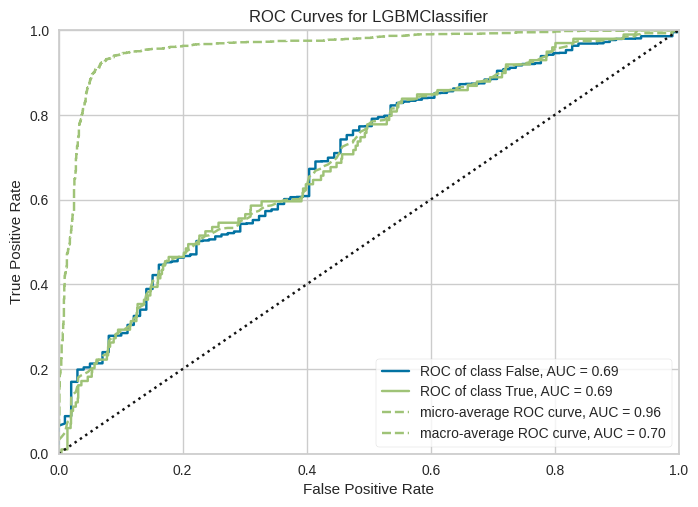

In [56]:
plot_model(tuned_lightgbm, plot='auc')

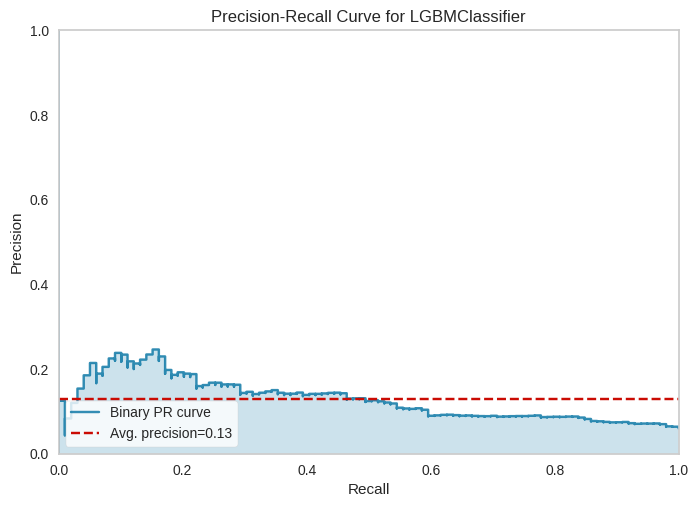

In [57]:
plot_model(tuned_lightgbm, plot='pr')

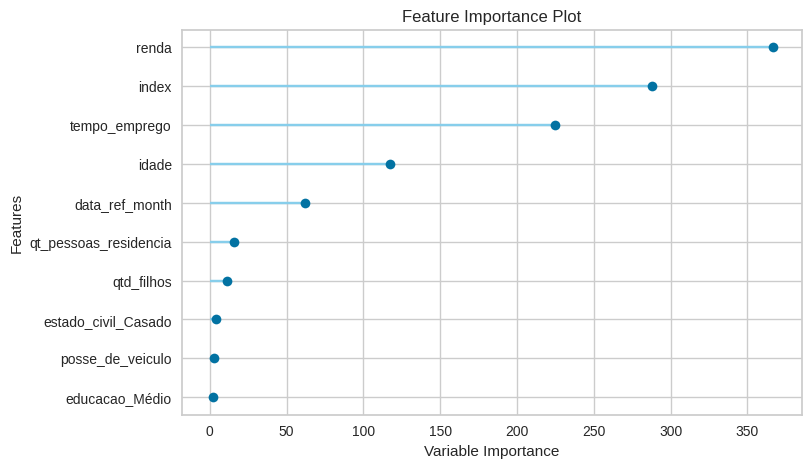

In [58]:
plot_model(tuned_lightgbm, plot='feature')

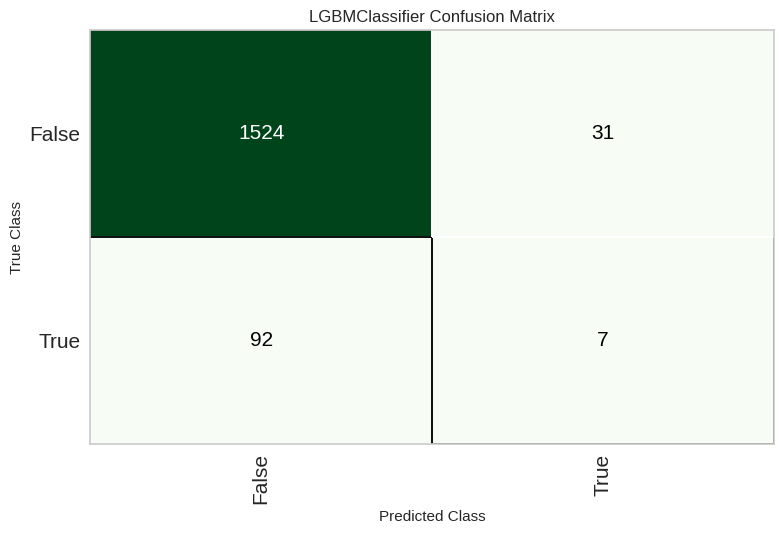

In [59]:
plot_model(tuned_lightgbm, plot='confusion_matrix')

In [60]:
predict_model(tuned_lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9256,0.6935,0.0707,0.1842,0.1022,0.0714,0.0804


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
7774,2015-01-01,5618,F,N,N,0.0,Empresário,Superior completo,Separado,Casa,32,13.210958,1.0,7069.720215,True,0,0.9956
52175,2015-02-01,15959,F,N,S,1.0,Assalariado,Médio,Casado,Casa,39,8.547945,3.0,1932.189941,False,0,0.9937
24428,2015-01-01,4983,F,N,S,0.0,Pensionista,Fundamental,Casado,Casa,65,NaN,2.0,5405.370117,False,0,0.9984
172612,2015-04-01,7504,F,N,S,0.0,Assalariado,Médio,Casado,Casa,39,2.901370,2.0,18838.650391,False,0,0.9947
529307,2015-11-01,6072,F,N,S,0.0,Pensionista,Médio,Separado,Casa,62,NaN,1.0,8889.269531,True,0,0.9976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5847,2015-01-01,15277,F,N,N,0.0,Pensionista,Médio,Casado,Casa,56,NaN,2.0,2768.000000,False,0,0.9958
106352,2015-03-01,14649,F,N,S,2.0,Servidor público,Médio,União,Casa,34,7.219178,4.0,20160.910156,False,0,0.9987
356549,2015-08-01,8841,F,S,S,2.0,Servidor público,Médio,Casado,Casa,36,14.386301,4.0,37168.648438,False,0,0.9906
345414,2015-07-01,16267,F,N,S,1.0,Empresário,Médio,União,Casa,32,8.128767,3.0,76863.453125,False,0,0.9997


In [61]:
final_lightgbm = finalize_model(tuned_lightgbm)

In [62]:
#Parâmetros finais do modelo Random Forest para deploy
print(final_lightgbm)

Pipeline(memory=Memory(location=None),
         steps=[('date_feature_extractor',
                 TransformerWrapper(exclude=None, include=['data_ref'],
                                    transformer=ExtractDateTimeFeatures(features=['day',
                                                                                  'month',
                                                                                  'year']))),
                ('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['index', 'qtd_filhos', 'idade',
                                             'tempo_emprego',
                                             'qt_pessoas_residencia', 'renda'],
                                    transformer=Sim...
                                boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, feature_fraction=0.5,
                                importance_type='split', lear

In [63]:
predict_model(final_lightgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9933,0.9985,0.8990,0.9889,0.9418,0.9383,0.9395


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
7774,2015-01-01,5618,F,N,N,0.0,Empresário,Superior completo,Separado,Casa,32,13.210958,1.0,7069.720215,True,1,0.8744
52175,2015-02-01,15959,F,N,S,1.0,Assalariado,Médio,Casado,Casa,39,8.547945,3.0,1932.189941,False,0,0.9040
24428,2015-01-01,4983,F,N,S,0.0,Pensionista,Fundamental,Casado,Casa,65,NaN,2.0,5405.370117,False,0,0.9989
172612,2015-04-01,7504,F,N,S,0.0,Assalariado,Médio,Casado,Casa,39,2.901370,2.0,18838.650391,False,0,0.9971
529307,2015-11-01,6072,F,N,S,0.0,Pensionista,Médio,Separado,Casa,62,NaN,1.0,8889.269531,True,1,0.7864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5847,2015-01-01,15277,F,N,N,0.0,Pensionista,Médio,Casado,Casa,56,NaN,2.0,2768.000000,False,0,0.9937
106352,2015-03-01,14649,F,N,S,2.0,Servidor público,Médio,União,Casa,34,7.219178,4.0,20160.910156,False,0,0.9981
356549,2015-08-01,8841,F,S,S,2.0,Servidor público,Médio,Casado,Casa,36,14.386301,4.0,37168.648438,False,0,0.9986
345414,2015-07-01,16267,F,N,S,1.0,Empresário,Médio,União,Casa,32,8.128767,3.0,76863.453125,False,0,0.9983


In [64]:
unseen_predictions = predict_model(final_lightgbm, data=df_valid)
unseen_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8101,0.6147,0.1700,0.2833,0.2125,0.1121,0.1168


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9


,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
600037,2016-01-01,16259,F,N,S,0.0,Pensionista,Médio,Solteiro,Casa,61,NaN,1.0,7757.140137,False,0,0.9553
632583,2016-01-01,1621,F,N,S,1.0,Empresário,Médio,Casado,Casa,42,2.895890,3.0,1495.420044,False,0,0.5596
733218,2016-03-01,15497,F,N,S,0.0,Pensionista,Fundamental,Solteiro,Casa,60,NaN,1.0,1000.989990,True,0,0.6343
726430,2016-03-01,14202,F,N,S,1.0,Assalariado,Médio,Casado,Casa,30,0.369863,3.0,1064.910034,False,1,0.5824
692570,2016-02-01,9827,F,N,N,0.0,Assalariado,Médio,Casado,Com os pais,27,4.515069,2.0,544.789978,False,0,0.9893


In [72]:
score = accuracy_score(unseen_predictions.mau, unseen_predictions.prediction_label)
print(f"Acurácia: {score*100:.2f}%")

Acurácia: 81.01%
